In [1]:
import numpy as np
import os
import sys

import torch
from torch import nn
from torchsummary import summary

import importlib

import matplotlib.pyplot as plt

sys.path.insert(0, "../src/")
import data
import model
import train

import nmrglue as ng
import scipy
import scipy.io

np.random.seed(123)

In [2]:
mod = "Ensemble_PIPNet_test"

in_dir = f"../data/{mod}/"
fig_dir = f"../figures/{mod}/"

load_model = True

eval_history = True

n_samples = 4

eval_evolution = True

eval_sparse = False

eval_noise = False
noise_levels = [1e-5, 1e-4, 1e-3]

vis_filters = False
max_filt=9
max_smpl=1
overwrite=False

eval_exp = False
evals = {"sel": True, "all": True, "rand": 5}
x_scales = [0.1, 0.2, 0.5, 1.]
exp_dir = f"../data/experimental_spectra/topspin/"
iso_dir = "../data/experimental_spectra/iso/"
exp_compounds = ["ampicillin", "aspala", "flutamide", "histidine", "thymol", "tyrosine"]
exp_range = {"ampicillin": [1500, 2500],
             "aspala": [1500, 2500],
             "flutamide": [1500, 2500],
             "histidine": [1500, 2500],
             "thymol": [1500, 2500],
             "tyrosine": [1500, 2500],
            }
exp_parts = {"ampicillin": ["NH3", "Ar6104b", "Me2"],
             "aspala": ["OH", "NHNH3", "CHCH", "CH2", "CH3"],
             "flutamide": ["H5", "H368", "H101112"],
             "histidine": ["H5", "H7", "H618", "H9", "H342"],
             "thymol": ["H7", "H321", "H4", "H556"],
             "tyrosine": ["COOH", "OH", "NH3H76", "H5823", "H3dia"],
            }
sel_wrs = [30000., 40000., 50000., 60000., 70000., 80000., 90000.]

In [3]:
if not os.path.exists(in_dir):
    raise ValueError(f"Unknown model: {mod}")
    
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

In [4]:
def clean_split(l, delimiter):
    """
    Split a line with the desired delimiter, ignoring delimiters present in arrays or strings
    
    Inputs: - l     Input line
    
    Output: - ls    List of sub-strings making up the line
    """
    
    # Initialize sub-strings
    ls = []
    clean_l = ""
    
    # Loop over all line characters
    in_dq = False
    in_sq = False
    arr_depth = 0
    for li in l:
        # Identify strings with double quotes
        if li == "\"":
            if not in_dq:
                in_dq = True
            else:
                in_dq = False
        
        # Identify strings with single quotes
        if li == "\'":
            if not in_sq:
                in_sq = True
            else:
                in_sq = False
        
        # Identify arrays
        if li == "[":
            if not in_sq and not in_dq:
                arr_depth += 1
        if li == "]":
            if not in_sq and not in_dq:
                arr_depth -= 1
        
        # If the delimiter is not within quotes or in an array, split the line at that character
        if li == delimiter and not in_dq and not in_sq and arr_depth == 0:
            ls.append(clean_l)
            clean_l = ""
        else:
            clean_l += li
    
    ls.append(clean_l)
        
    return ls

In [5]:
def get_array(l):
    """
    Get the values in an array contained in a line
    
    Input:  - l         Input line
    
    Output: - vals      Array of values
    """
    
    # Identify empty array
    if l.strip() == "[]":
        return []
    
    # Initialize array
    vals = []
    clean_l = ""
    
    # Loop over all line characters
    arr_depth = 0
    for li in l:
    
        # Identify end of array
        if li == "]":
            arr_depth -= 1
            
            # Check that there are not too many closing brackets for the opening ones
            if arr_depth < 0:
                raise ValueError("Missing \"[\" for matching the number of \"]\"")
        
        # If we are within the array, extract the character
        if arr_depth > 0:
            clean_l += li
    
        # Identify start of array
        if li == "[":
            arr_depth += 1
    
    # Check that the array is properly closed at the end
    if arr_depth > 0:
        raise ValueError("Missing \"]\" for matching the number of \"[\"")
    
    # Extract elements in the array
    ls = clean_split(clean_l, ",")
    
    # Get the value of each element in the array
    for li in ls:
        vals.append(get_val(li.strip()))

    return vals

In [6]:
def get_val(val):
    
    # Remove tailing comma
    if val.endswith(","):
        val = val[:-1]
    
    # Float / Int
    if val.isnumeric():
        
        if "." in val:
            return float(val)
        else:
            return int(val)
    
    # Bool
    if val.lower() == "true":
        return True
    if val.lower() == "false":
        return False
    
    # String
    if val.startswith("\""):
        return val.split("\"")[1]
    
    # List
    if val.startswith("["):
        
        return get_array(val)
    
    # Try to return a float anyway
    return float(val)

In [7]:
# Get model architecture
with open(mod + ".py", "r") as F:
    lines = F.read().split("\n")

model_pars = {}
in_pars = False

# Parse script
for l in lines:
    
    # Identify model parameter block start
    if "model_pars = " in l:
        in_pars = True
    
    # Identify model parameter block end
    if l.strip() == ")":
        in_pars = False
    
    if in_pars:
        # Get line
        if "(" in l:
            L = l.split("(")[1].split("#")[0]
        else:
            L = l.strip().split("#")[0]
        
        key, val = L.split("=")
        
        v = get_val(val.strip())
        
        model_pars[key.strip()] = v

model_pars["noise"] = 0.

In [8]:
# Get data parameters
with open(mod + ".py", "r") as F:
    lines = F.read().split("\n")

data_pars = {}
in_pars = False

# Parse script
for l in lines:
    
    # Identify model parameter block start
    if "data_pars = " in l:
        in_pars = True
    
    # Identify model parameter block end
    if l.strip() == ")":
        in_pars = False
    
    if in_pars:
        # Get line
        if "(" in l:
            L = l.split("(")[1].split("#")[0]
        else:
            L = l.strip().split("#")[0]
        
        if "=" in L:
        
            key, val = L.split("=")
        
            v = get_val(val.strip())
        
            data_pars[key.strip()] = v

dataset = data.PIPDataset(**data_pars)

In [9]:
# Load loss and learning rate
all_lrs = np.load(in_dir + "all_lrs.npy")
all_losses = np.load(in_dir + "all_losses.npy")
all_val_losses = np.load(in_dir + "all_val_losses.npy")

mean_losses = np.mean(all_losses, axis=1)
mean_val_losses = np.mean(all_val_losses, axis=1)

n_chk = all_losses.shape[0]
best_chk = np.argmin(mean_val_losses)
print(best_chk)

3


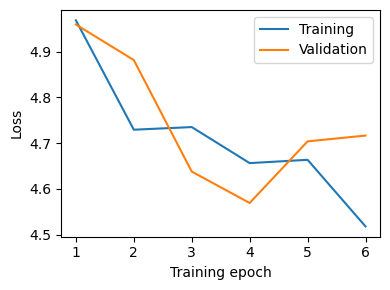

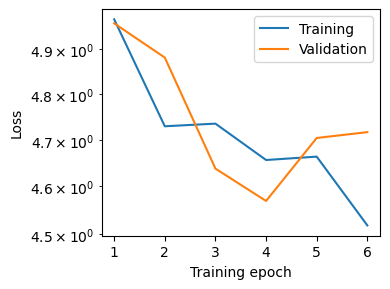

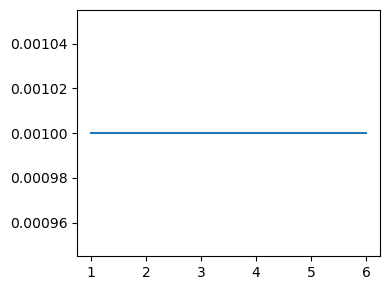

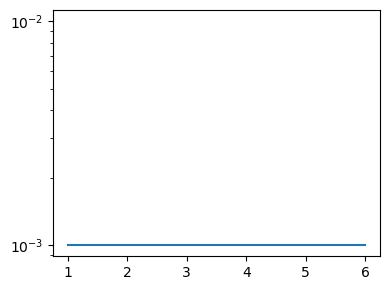

In [10]:
# Plot loss
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.plot(range(1, n_chk+1), mean_losses)
ax.plot(range(1, n_chk+1), mean_val_losses)

ax.set_xlabel("Training epoch")
ax.set_ylabel("Loss")

ax.legend(["Training", "Validation"])

fig.tight_layout()

plt.savefig(fig_dir + "loss.pdf")

plt.show()
plt.close()

# Plot loss, log
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.semilogy(range(1, n_chk+1), mean_losses)
ax.semilogy(range(1, n_chk+1), mean_val_losses)

ax.set_xlabel("Training epoch")
ax.set_ylabel("Loss")

ax.legend(["Training", "Validation"])

fig.tight_layout()

plt.savefig(fig_dir + "loss_log.pdf")

plt.show()
plt.close()

# Plot learning rate
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.plot(range(1, n_chk+1), np.mean(all_lrs, axis=1))

fig.tight_layout()

plt.savefig(fig_dir + "lrs.pdf")

plt.show()
plt.close()

# Plot learning rate, log
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.semilogy(range(1, n_chk+1), np.mean(all_lrs, axis=1))

fig.tight_layout()

plt.savefig(fig_dir + "lrs_log.pdf")

plt.show()
plt.close()

In [11]:
d = 0.5

mean_losses_dif = np.abs(mean_losses[1:] - mean_losses[:-1])
rel_diffs = mean_losses_dif / mean_losses[:-1]
jumps = np.where(rel_diffs > 0.3)[0]+1

if len(jumps) > 0:

    fig = plt.figure(figsize=(4,3))

    axs = []
    for i in range(len(jumps) + 1):
        axs.append(fig.add_subplot(len(jumps)+1, 1,i+1))

        # Plot broken axes markers
        if i > 0:
            axs[i].plot([0, 1], [1, 1], transform=axs[i].transAxes, marker=[(-1, -d), (1, d)],
                        markersize=12, linestyle="none", color="k", mec="k", mew=1, clip_on=False)

            axs[i].spines["top"].set_visible(False)

        if i < len(jumps):
            axs[i].plot([0, 1], [0, 0], transform=axs[i].transAxes, marker=[(-1, -d), (1, d)],
                        markersize=12, linestyle="none", color="k", mec="k", mew=1, clip_on=False)

            axs[i].spines["bottom"].set_visible(False)
            axs[i].set_xticks([])

        h1 = axs[i].plot(range(1, n_chk+1), mean_losses, ".-")
        h2 = axs[i].plot(range(1, n_chk+1), mean_val_losses, ".-")
        axs[i].set_xlim(1, n_chk)

        if i == 0:
            M = np.max(mean_losses[:jumps[i]])
            M = max(M, np.max(mean_val_losses[:jumps[i]]))
            m = np.min(mean_losses[:jumps[i]])
            m = min(M, np.min(mean_val_losses[:jumps[i]]))

        elif i == len(jumps):
            M = np.max(mean_losses[jumps[i-1]:])
            M = max(M, np.max(mean_val_losses[jumps[i-1]:]))
            m = np.min(mean_losses[jumps[i-1]:])
            m = min(m, np.min(mean_val_losses[jumps[i-1]:]))

        else:
            M = np.max(mean_losses[jumps[i-1]:jumps[i]])
            M = max(M, np.max(mean_val_losses[jumps[i-1]:jumps[i]]))
            m = np.min(mean_losses[jumps[i-1]:jumps[i]])
            m = min(m, np.min(mean_val_losses[jumps[i-1]:jumps[i]]))

        r = M - m

        axs[i].set_ylim(m - 0.1 * r, M + 0.1 * r)

    axs[0].legend([h1[0], h2[0]], ["Training", "Validation"])

    fig.tight_layout()

    plt.savefig(fig_dir + "loss_split.pdf")

    plt.show()
    plt.close()

# Evaluate the model history

In [21]:
def plot_checkpoint(X, y_trg, y_pred, y_std, ys=None, input_factor=0.5, show=True, save=None,
                    c_start=[0., 1., 1.], c_stop=[0., -1., 0.], c2_start=[1., 1., 0.], c2_stop=[0., -1., 0.]):
    
    if y_std is None:
        y_std = [[] for _ in range(X.shape[0])]
    
    n_pts = X.shape[-1]
    
    n = X.shape[1] - 1
    
    colors = [[c0 + (i / n) * c1 for c0, c1 in zip(c_start, c_stop)] for i in range(n+1)]
    
    if ys is not None:
        n2 = ys.shape[0] - 1
        colors2 = [[c0 + (i / n2) * c1 for c0, c1 in zip(c2_start, c2_stop)] for i in range(n2+1)]
    
    for i, (Xi, yi_trg, yi_pred, yi_std) in enumerate(zip(X, y_trg, y_pred, y_std)):
        
        for k in range(yi_pred.shape[0]):

            # Print target vs. pred
            fig = plt.figure(figsize=(4,3))
            ax = fig.add_subplot(1,1,1)

            ax.plot(yi_trg[0], linewidth=1.)
            ax.plot(yi_pred[k], linewidth=1.)

            if len(yi_std) > 0:
                ax.fill_between(range(n_pts), yi_pred[k] - yi_std[k], yi_pred[k] + yi_std[k], facecolor="C1", alpha=0.3)

            ax.legend(["Ground-truth", "Prediction"])

            if show:
                plt.show()

            if save is not None:
                plt.savefig(save + f"sample_{i+1}_pred_{k+1}.pdf")

            plt.close()
        
        if ys is not None:
            # Print target vs. all preds
            fig = plt.figure(figsize=(4,3))
            ax = fig.add_subplot(1,1,1)

            h1 = ax.plot(yi_trg[0], linewidth=1.)
            
            for c, yi in zip(colors2, ys[:, i, 0, :]):
                ax.plot(yi, linewidth=1., color=c)
                
            h2 = ax.plot(yi_pred[0], linewidth=1., color="k")
            
            ax.legend([h1[0], h2[0]], ["Ground-truth", "Prediction"])

            if show:
                plt.show()

            if save is not None:
                plt.savefig(save + f"sample_{i+1}_all_preds.pdf")

            plt.close()
            
            for j in range(ys.shape[0]):
                
                for k in range(ys.shape[2]):

                    # Print target vs. all preds
                    fig = plt.figure(figsize=(4,3))
                    ax = fig.add_subplot(1,1,1)

                    h1 = ax.plot(yi_trg[0], linewidth=1.)

                    ax.plot(ys[j, i, k, :], linewidth=1., color=colors2[j])

                    h2 = ax.plot(yi_pred[k], linewidth=1., color="k")

                    ax.legend([h1[0], h2[0]], ["Ground-truth", "Prediction"])

                    if show:
                        plt.show()

                    if save is not None:
                        plt.savefig(save + f"sample_{i+1}_pred_{j+1}_{k+1}.pdf")

                    plt.close()
        
        # Print input and target
        fig = plt.figure(figsize=(4,3))
        ax = fig.add_subplot(1,1,1)
        
        for x, c in zip(Xi[:, 0, :], colors):
            ax.plot(x / np.max(Xi[:, 0, :]), linewidth=1., color=c)
        ax.plot(yi_trg[0] / np.max(yi_trg[0]) * input_factor, "r", linewidth=1.)
        
        if show:
            plt.show()
            
        if save is not None:
            plt.savefig(save + f"sample_{i+1}_input.pdf")
            
        plt.close()
    
    return

In [13]:
if eval_history:

    fdir = fig_dir + "eval_history/"

    if not os.path.exists(fdir):
        os.mkdir(fdir)

    for i in range(n_chk):

        d = fdir + f"checkpoint_{i+1}/"
        if not os.path.exists(d):
            os.mkdir(d)

        X = np.load(in_dir + f"checkpoint_{i+1}_in.npy")
        y_trg = np.load(in_dir + f"checkpoint_{i+1}_trg.npy")
        y_pred = np.load(in_dir + f"checkpoint_{i+1}_pred.npy")
        y_std = np.load(in_dir + f"checkpoint_{i+1}_std.npy")

        plot_checkpoint(X, y_trg, y_pred, y_std, show=False, save=d)

print("All done!")

All done!


# Load model and generate dataset

In [14]:
if eval_evolution or eval_sparse or eval_noise or eval_exp or vis_filters:

    net = model.ConvLSTMEnsemble(**model_pars)
    net.eval()
    
    if eval_evolution or eval_sparse or eval_noise or vis_filters:

        X = []
        y = []

        for i in range(n_samples):
            Xi, _, yi = dataset.__getitem__(0)
            X.append(Xi.unsqueeze(0))
            y.append(yi.unsqueeze(0))

        X = torch.cat(X, dim=0)
        y = torch.cat(y, dim=0)

In [15]:
def print_filter(X, filt, max_filt=-1, max_smpl=-1, encode_mas=False, show=True, save=None, xl=[0., 1.], yl=[0., 1.], sig=True):
    
    n_filt = filt.shape[1]
    if max_filt > 0:
        n_filt = min(n_filt, max_filt)
    
    df = torch.max(filt[:, :, 10:-10], axis=-1)[0] - torch.min(filt[:, :, 10:-10], axis=-1)[0]

    n_smpl = X.shape[0]
    if max_smpl > 0:
        n_smpl = min(n_smpl, max_smpl)
    n_pts = X.shape[-1]
    n_row = int(np.sqrt(n_filt))
    n_col = int(n_filt / n_row)
    n_col += 1 if (n_filt / n_row) > int(n_filt / n_row) else 0
    
    for sample in range(n_smpl):
        
        f_inds = torch.argsort(df[sample], descending=True)
        f_inds = f_inds[:n_filt]

        fig = plt.figure(figsize=(5*n_col,3*n_row))
        axs = []
        for row in range(n_row):
            for col in range(n_col):
                axs.append(fig.add_subplot(n_row,n_col,(row * n_col) + col + 1))

        if sig:
            for i, f_ind in enumerate(f_inds):
                
                if i % n_col != 0:
                    axs[i].set_yticks([])
                
                if int(i / n_row + 1) < n_row:
                    axs[i].set_xticks([])
                    
                vmin = torch.min(filt[sample, f_ind])
                vmax = torch.max(filt[sample, f_ind])
                for xi in X[sample]:
                    
                    cb = axs[i].scatter(range(n_pts), xi, s=5, c=filt[sample, f_ind],
                                        cmap="jet", marker=".", vmin=vmin, vmax=vmax)

                fig.colorbar(cb, ax=axs[i])

        else:
            for i, f_ind in enumerate(f_inds):
                
                vmin = torch.min(filt[sample, f_ind])
                vmax = torch.max(filt[sample, f_ind])
                for xi in X[sample]:
                    cb = axs[i].scatter(range(n_pts), xi, s=5, c=filt[sample, f_ind],
                                        cmap="jet", marker=".", vmin=vmin, vmax=vmax)
                    
                fig.colorbar(cb, ax=axs[i])
                        
        for i in range(n_filt):
            axs[i].set_xlim(xl)
            axs[i].set_ylim(yl)
            
        fig.tight_layout()
        
        if show:
            plt.show()
        
        if save is not None:
            plt.savefig(save + f"_sample_{sample+1}.pdf")
            
        plt.close()
    
    return

In [16]:
if vis_filters:
    fdir = fig_dir + "vis_filters/"
    
    if not os.path.exists(fdir):
        os.mkdir(fdir)
        
    xl = [-1, X.shape[-1]]
    dy = (torch.max(X[:, :, 0, :]) - torch.min(X[:, :, 0, :])) * 0.05
    yl = [torch.min(X[:, :, 0, :]) - dy, torch.max(X[:, :, 0, :]) + dy]

    for ind_model, model in enumerate(net.models):

        print(f"Model {ind_model+1}/{len(net.models)}...")

        for ind_cell, cell in enumerate(net.models[ind_model].cell_list):

            hidden_state = net.models[ind_model]._init_hidden(batch_size=X.shape[0], image_size=X.shape[-1])
            X1 = net.models[ind_model]._batch_input(X)
            X_vis = net.models[ind_model]._batch_input(X[:, :, :1, :])
            cur_layer_input = net.models[ind_model]._batch_input(X)

            if ind_cell > 0:
                for prev_cell in range(ind_cell):
                    h, c = hidden_state[prev_cell]
                    output_inner = []
                    for t in range(cur_layer_input.shape[1]):
                        h, c = net.models[ind_model].cell_list[prev_cell].forward(cur_layer_input[:, t], cur_state=[h, c])
                        output_inner.append(h)
                    cur_layer_input = torch.stack(output_inner, dim=1)

            print(f"  Cell {ind_cell+1}/{len(net.models[ind_model].cell_list)}...")
            h, c = hidden_state[ind_cell]

            all_h = []
            all_c = []
            all_x = []
            all_i = []
            all_f = []
            all_o = []
            all_g = []
            for t in range(cur_layer_input.shape[1]):
                
                print(f"    State {t+1}/{cur_layer_input.shape[1]}...")
                i, f, o, g, h2, c2 = net.models[ind_model].cell_list[ind_cell].analyze(cur_layer_input[:, t], [h, c])

                h = h2.detach().clone()
                c = c2.detach().clone()

                if overwrite or f"model_{ind_model+1}_cell_{ind_cell+1}_i_{t+1}_sample_1.png" not in os.listdir(fdir):
                    print("      Printing input gate...")
                    print_filter(X_vis[:, t].detach().clone(), i.detach().clone(), max_filt=max_filt, max_smpl=max_smpl,
                                 encode_mas=data_pars["encode_w"], show=False,
                                 save=f"{fdir}model_{ind_model+1}_cell_{ind_cell+1}_i_{t+1}", xl=xl, yl=yl, sig=True)
                    
                if overwrite or f"model_{ind_model+1}_cell_{ind_cell+1}_f_{t+1}_sample_1.png" not in os.listdir(fdir):
                    print("      Printing forget gate...")
                    print_filter(X_vis[:, t].detach().clone(), f.detach().clone(), max_filt=max_filt, max_smpl=max_smpl,
                                 encode_mas=data_pars["encode_w"], show=False,
                                 save=f"{fdir}model_{ind_model+1}_cell_{ind_cell+1}_f_{t+1}", xl=xl, yl=yl, sig=True)
                    
                if overwrite or f"model_{ind_model+1}_cell_{ind_cell+1}_o_{t+1}_sample_1.png" not in os.listdir(fdir):
                    print("      Printing output gate...")
                    print_filter(X_vis[:, t].detach().clone(), o.detach().clone(), max_filt=max_filt, max_smpl=max_smpl,
                                 encode_mas=data_pars["encode_w"], show=False,
                                 save=f"{fdir}model_{ind_model+1}_cell_{ind_cell+1}_o_{t+1}", xl=xl, yl=yl, sig=True)
                    
                if overwrite or f"model_{ind_model+1}_cell_{ind_cell+1}_g_{t+1}_sample_1.png" not in os.listdir(fdir):
                    print("      Printing cell state update...")
                    print_filter(X_vis[:, t].detach().clone(), g.detach().clone(), max_filt=max_filt, max_smpl=max_smpl,
                                 encode_mas=data_pars["encode_w"], show=False,
                                 save=f"{fdir}model_{ind_model+1}_cell_{ind_cell+1}_g_{t+1}", xl=xl, yl=yl, sig=False)
                    
                if overwrite or f"model_{ind_model+1}_cell_{ind_cell+1}_h_{t+1}_sample_1.png" not in os.listdir(fdir):
                    print("      Printing LSTM output...")
                    print_filter(X_vis[:, t].detach().clone(), h.detach().clone(), max_filt=max_filt, max_smpl=max_smpl,
                                 encode_mas=data_pars["encode_w"], show=False,
                                 save=f"{fdir}model_{ind_model+1}_cell_{ind_cell+1}_h_{t+1}", xl=xl, yl=yl, sig=False)
                    
                if overwrite or f"model_{ind_model+1}_cell_{ind_cell+1}_c_{t+1}_sample_1.png" not in os.listdir(fdir):
                    print("      Printing cell state...")
                    print_filter(X_vis[:, t].detach().clone(), c.detach().clone(), max_filt=max_filt, max_smpl=max_smpl,
                                 encode_mas=data_pars["encode_w"], show=False,
                                 save=f"{fdir}model_{ind_model+1}_cell_{ind_cell+1}_c_{t+1}", xl=xl, yl=yl, sig=False)

In [18]:
sel_chk = "all"

In [20]:
ys.shape

(5, 4, 3, 256)

In [23]:
if eval_evolution:

    fdir = fig_dir + "eval_evolution/"

    if not os.path.exists(fdir):
        os.mkdir(fdir)

    for i in range(n_chk):
        
        if sel_chk == "all" or i in sel_chk:

            print(f"Checkpoint {i+1}/{n_chk}...")

            d = fdir + f"checkpoint_{i+1}/"
            if not os.path.exists(d):
                os.mkdir(d)

            print("  Loading model...")
            net.load_state_dict(torch.load(in_dir + f"checkpoint_{i+1}_network", map_location=torch.device("cpu")))
            net.eval()

            print("  Performing predictions...")
            y_pred, y_std, ys = net(X)
            y_pred = y_pred.detach().numpy()
            y_std = y_std.detach().numpy()
            ys = ys.detach().numpy()

            print("  Plotting data...")
            plot_checkpoint(X.numpy(), y.numpy(), y_pred, y_std, ys=ys, show=False, save=d)
        
print("All done!")

Checkpoint 1/6...
  Loading model...
  Performing predictions...
  Plotting data...
Checkpoint 2/6...
  Loading model...
  Performing predictions...
  Plotting data...
Checkpoint 3/6...
  Loading model...
  Performing predictions...
  Plotting data...
Checkpoint 4/6...
  Loading model...
  Performing predictions...
  Plotting data...


KeyboardInterrupt: 

In [19]:
if eval_sparse:
    
    # Load best model
    net.load_state_dict(torch.load(in_dir + f"checkpoint_{best_chk+1}_network", map_location=torch.device("cpu")))

    fdir = fig_dir + "eval_sparse/"

    if not os.path.exists(fdir):
        os.mkdir(fdir)
    
    # Lower MAS inputs
    print("Lower MAS range...")
    for i in range(model_pars["batch_input"], X.shape[1]+1):
        
        d = fdir + f"lower_{i}_rates/"
        if not os.path.exists(d):
            os.mkdir(d)
        
        print("  Performing predictions...")
        y_pred, y_std, _ = net(X[:, :i])
        y_pred = y_pred.detach().numpy()
        y_std = y_std.detach().numpy()
        
        print("  Plotting data...")
        plot_checkpoint(X, y, y_std, y_pred, show=False, save=d)
    
    # Higher MAS inputs
    print("Higher MAS range...")
    for i in range(model_pars["batch_input"], X.shape[1]+1):
        
        d = fdir + f"higher_{i}_rates/"
        if not os.path.exists(d):
            os.mkdir(d)
        
        print("  Performing predictions...")
        y_pred, y_std, _ = net(X[:, -i:])
        y_pred = y_pred.detach().numpy()
        y_std = y_std.detach().numpy()
        
        print("  Plotting data...")
        plot_checkpoint(X, y, y_std, y_pred, show=False, save=d)
        
print("All done!")

All done!


In [20]:
if eval_noise:
    
    # Load best model
    net.load_state_dict(torch.load(in_dir + f"checkpoint_{best_chk+1}_network", map_location=torch.device("cpu")))

    fdir = fig_dir + "eval_noise/"

    if not os.path.exists(fdir):
        os.mkdir(fdir)
    
    for noise in noise_levels:
        
        break
        
        print(f"Noise level {noise:.0e}...")
        
        d = fdir + f"noise_level_{noise:.0e}/"
        if not os.path.exists(d):
            os.mkdir(d)
        
        # Generate noisy data
        X2 = X.clone() + (torch.randn(X.shape) * noise)
        
        print("  Performing predictions...")
        y_pred, y_std, _ = net(X2)
        y_pred = y_pred.detach().numpy()
        y_std = y_std.detach().numpy()
        
        print("  Plotting data...")
        plot_checkpoint(X2, y, y_std, y_pred, show=False, save=d)
        
        print("Normalizing noisy spectra...")
        
        d = fdir + f"noise_level_{noise:.0e}_norm/"
        if not os.path.exists(d):
            os.mkdir(d)
        
        vals_min, _ = torch.min(X2[:, :, 0], dim=-1)
        vals_min = torch.unsqueeze(vals_min, -1)
        X2[:, :, 0] -= vals_min
        
        print("  Performing predictions...")
        y_pred, y_std, _ = net(X2)
        y_pred = y_pred.detach().numpy()
        y_std = y_std.detach().numpy()
        
        print("  Plotting data...")
        plot_checkpoint(X2, y, y_std, y_pred, show=False, save=d)
    
print("All done!")

All done!


# Evaluate experimental data

In [21]:
def load_topspin_spectrum(d):
    
    pd = f"{d}pdata/1/"
    
    fr = pd + "1r"
    fi = pd + "1i"
    
    try:

        with open(fr, "rb") as F:
            dr = np.fromfile(F, np.int32).astype(float)

        with open(fi, "rb") as F:
            di = np.fromfile(F, np.int32).astype(float)
        
        with open(f"{d}acqus", "r") as F:
            lines = F.read().split("\n")
        
        for l in lines:
            if l.startswith("##$MASR"):
                wr = float(l.split("=")[1].strip())
                
        with open(f"{pd}procs", "r") as F:
            lines = F.read().split("\n")

        for l in lines:
            if l.startswith("##$SI="):
                n_pts = int(l.split("=")[1].strip())

            if l.startswith("##$OFFSET="):
                offset = float(l.split("=")[1].strip())

            if l.startswith("##$SF="):
                SF = float(l.split("=")[1].strip())

            if l.startswith("##$SW_p="):
                SW = float(l.split("=")[1].strip())

        df = SW / n_pts

        ppm = offset - np.arange(SW, step=df) / SF

    except:
        dr = np.array([])
        di = np.array([])
        wr = -1
    
    return dr, di, wr, ppm

In [22]:
def extract_exp(in_dir, compound, parts, n="4k"):
    
    d = f"{in_dir}{compound}_{n}/"
    
    ys_part_means = []
    ys_part_stds = []
    ys_ppms = []
    
    for p in parts:
        
        ys_part = []

        i_guess = 1
        while os.path.exists(f"{d}{compound[:3]}_{p}_guess_r{i_guess}.mat"):

            m = scipy.io.loadmat(f"{d}{compound[:3]}_{p}_guess_r{i_guess}.mat")

            ys_part.append(m["x"][:-3])
            ppm = m["ppm"][0, m["range"][0]]
            
            i_guess += 1
        
        ys_ppms.append(ppm)
        ys_part = np.concatenate(ys_part, axis=1)
        ys_part_means.append(np.mean(ys_part, axis=1))
        ys_part_stds.append(np.std(ys_part, axis=1))
    
    ys_ppms = np.concatenate(ys_ppms, axis=0)
    ys_part_means = np.concatenate(ys_part_means, axis=0)
    ys_part_stds = np.concatenate(ys_part_stds, axis=0)
    
    ws = m["masrates"][0]
    ppm = m["ppm"][0]
    X = m["signal"]
    
    sorted_inds = np.argsort(ws)
    X = X[sorted_inds]
    ws = ws[sorted_inds]
    
    return ppm, X, ys_ppms, ys_part_means, ys_part_stds, ws

In [23]:
def make_input(X, ws, data_pars, x_max=0.25):
    
    inds = np.argsort(ws)
    X_torch = torch.Tensor(X[inds])
    X_torch = torch.unsqueeze(X_torch, dim=0)
    X_torch = torch.unsqueeze(X_torch, dim=2)
    
    X_torch /= torch.max(X_torch)
    X_torch *= x_max
    
    if data_pars["encode_w"]:
        W = torch.Tensor(ws[inds])
        W = torch.unsqueeze(W, dim=0)
        W = torch.unsqueeze(W, dim=2)
        W = torch.unsqueeze(W, dim=3)
        W = W.repeat(1, 1, 1, X_torch.shape[-1])
        
        if data_pars["norm_wr"]:
            W -= data_pars["mas_w_range"][0]
            W /= data_pars["mas_w_range"][1] - data_pars["mas_w_range"][0]
    
    X_torch = torch.cat([X_torch, W], dim=2)
    
    return X_torch, ws[inds]

In [24]:
def plot_exp_vs_pred(ppm, X, y_pred, y_std, ppm_trg, y_trg_avg, y_trg_std, show=True, save=None,
                     y0_pred=0., y0_trg=0., reverse_trg=False, xl=[20., -5.], c0=[0., 1., 1.], dc = [0., -1., 0.]):
    
    # Initialize figure
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(1,1,1)
    
    n = X.shape[0]
    colors = [[ci + (dci * i / (n-1)) for ci, dci in zip(c0, dc)] for i in range(n)]
    
    # Plot inputs
    for c, x in zip(colors, X):
        ax.plot(ppm, x, color=c, linewidth=1)
    
    # Plot predictions
    ax.plot(ppm, y_pred + y0_pred, "r", linewidth=1)
    ax.fill_between(ppm, y_pred - y_std + y0_pred, y_pred + y_std + y0_pred, color="r", alpha=0.3)
    
    # Plot target
    if reverse_trg:
        ax.plot(ppm_trg, -y_trg_avg + y0_trg, "k", linewidth=1)
        ax.fill_between(ppm_trg, -y_trg_avg - y_trg_std + y0_trg, -y_trg_avg + y_trg_std + y0_trg, color="k", alpha=0.3)
        
    else:
        ax.plot(ppm_trg, y_trg_avg + y0_trg, "k", linewidth=1)
        ax.fill_between(ppm_trg, y_trg_avg - y_trg_std + y0_trg, y_trg_avg + y_trg_std + y0_trg, color="k", alpha=0.3)
    
    # Update axis
    ax.set_xlim(xl)
    ax.set_yticks([])
    ax.set_xlabel("Chemical shift [ppm]")
    
    # Cleanup layout
    fig.tight_layout()
    
    # Save figure
    if save:
        plt.savefig(save)
    
    # Show figure
    if show:
        plt.show()
        
    # Close figure
    plt.close()
    
    return

In [25]:
evals

{'sel': True, 'all': True, 'rand': 5}

ampicillin


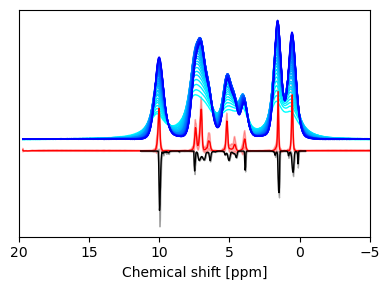

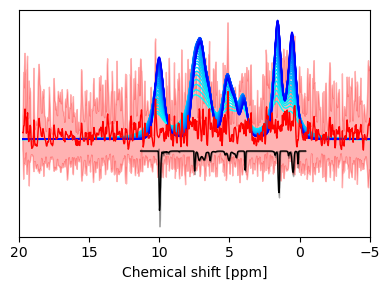

[30000 32000 34000 42000 46000 54000 74000 94000]


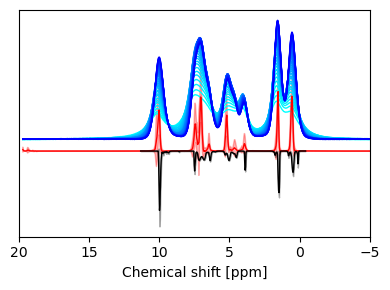

[34000 38000 50000 60000 66000 74000 78000 90000]


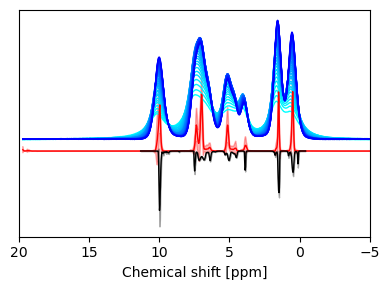

[34000 36000 46000 48000 74000 84000 92000 96000]


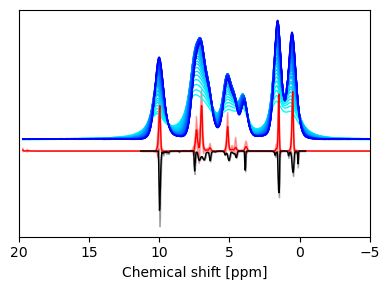

[24000 32000 34000 38000 40000 70000 84000 86000]


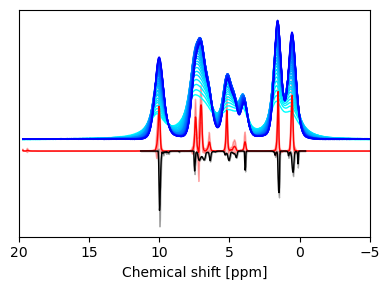

[24000 42000 50000 64000 70000 76000 90000 92000]


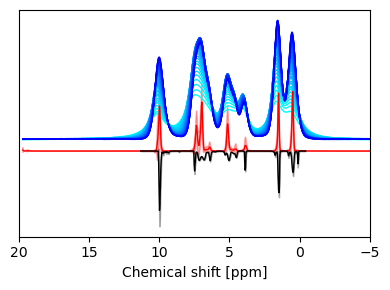

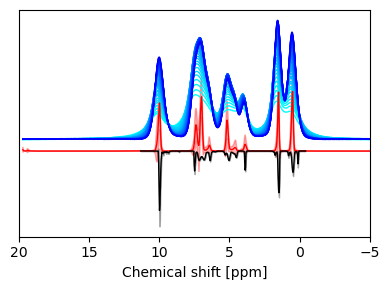

aspala


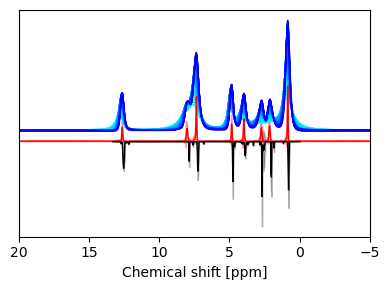

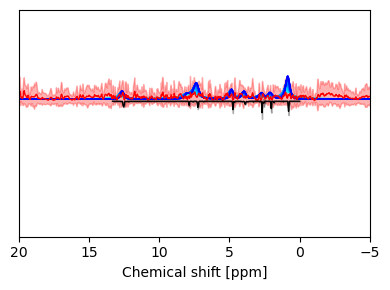

[40000 44000 54000 64000 68000 80000 86000 92000]


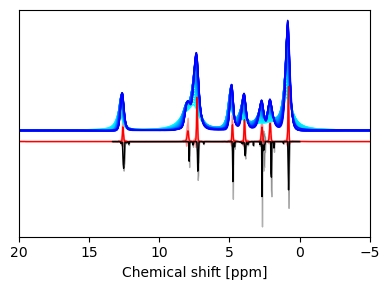

[32000 50000 56000 58000 68000 76000 86000 96000]


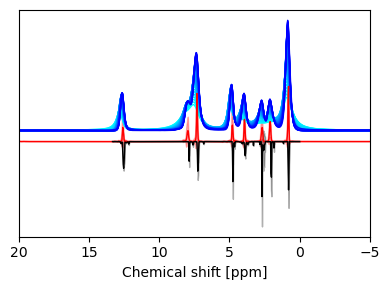

[ 32000  44000  54000  64000  72000  86000  98000 100000]


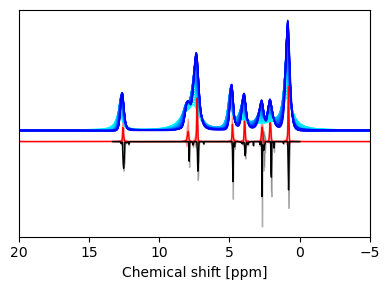

[48000 50000 62000 66000 68000 70000 72000 74000]


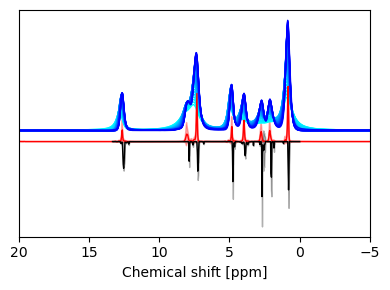

[32000 36000 44000 54000 68000 72000 92000 98000]


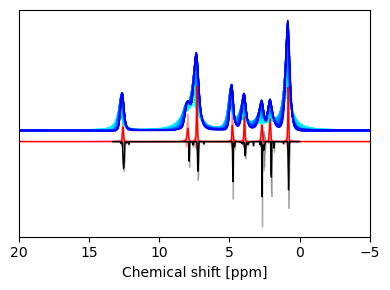

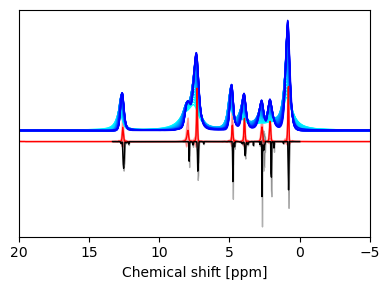

flutamide


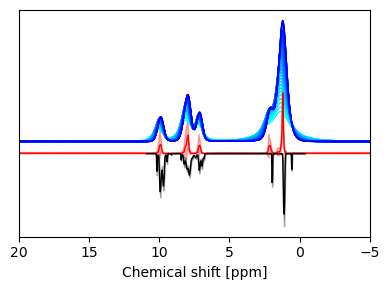

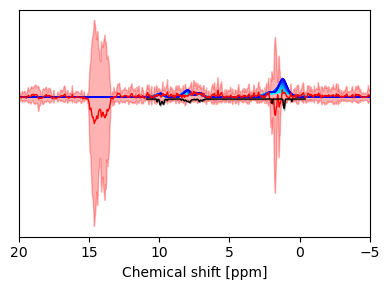

[24000 28000 32000 40000 58000 62000 70000 92000]


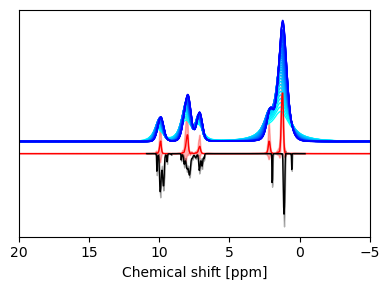

[22000 28000 58000 70000 76000 78000 84000 88000]


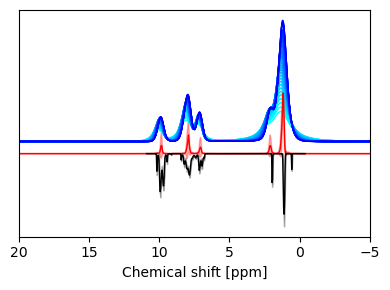

[34000 36000 40000 64000 78000 82000 84000 98000]


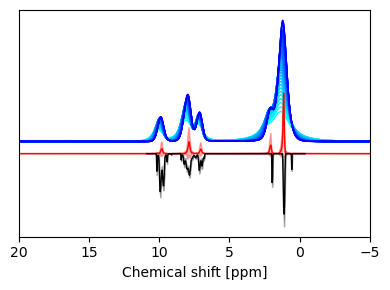

[ 24000  28000  48000  66000  74000  78000  90000 100000]


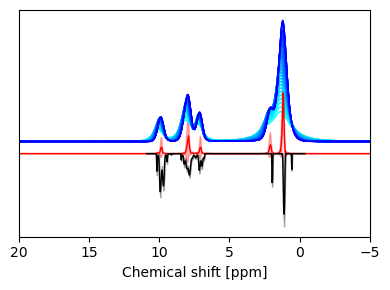

[24000 28000 48000 76000 84000 86000 90000 92000]


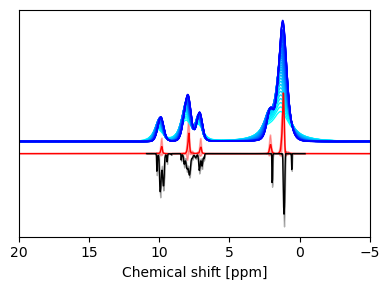

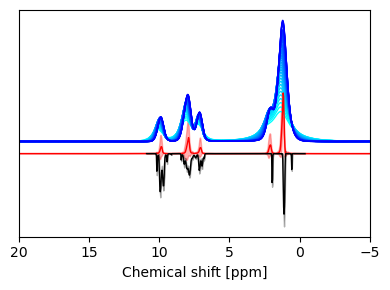

histidine


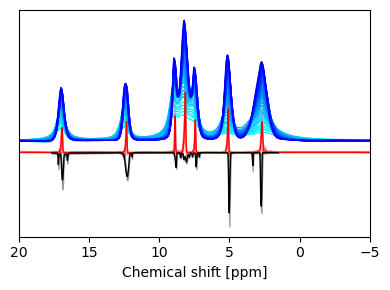

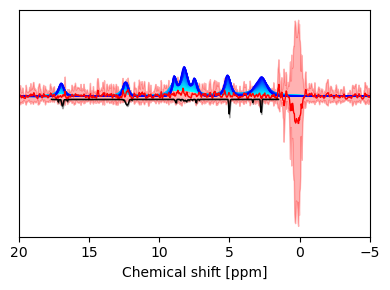

[22000 24000 56000 58000 62000 64000 74000 82000]


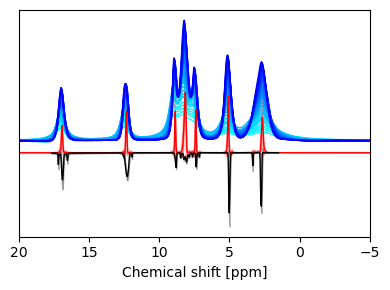

[34000 42000 54000 58000 60000 70000 92000 94000]


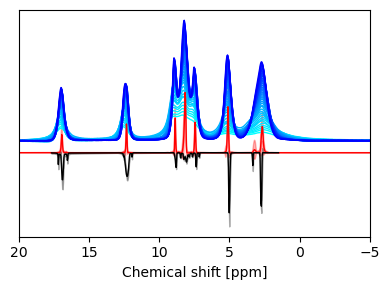

[26000 38000 56000 74000 76000 82000 92000 96000]


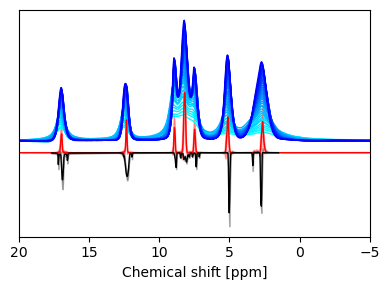

[22000 32000 52000 56000 58000 66000 86000 92000]


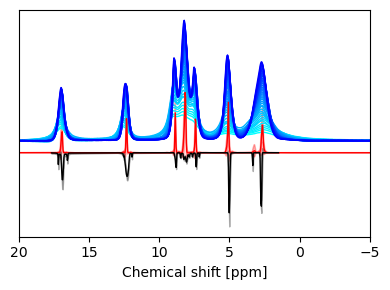

[26000 30000 32000 38000 52000 56000 58000 68000]


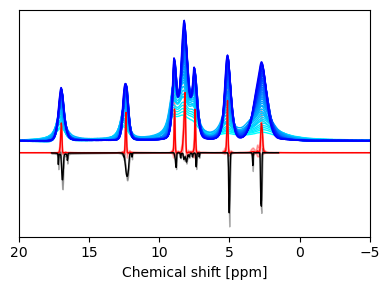

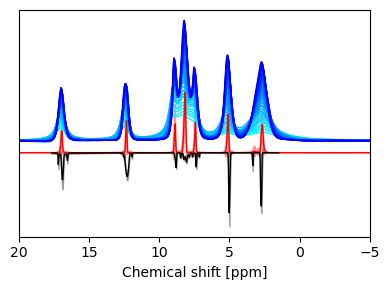

thymol


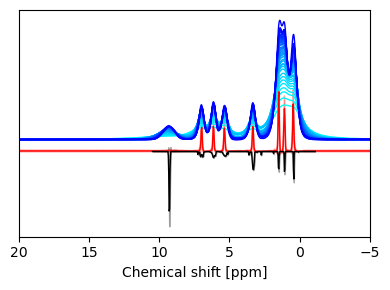

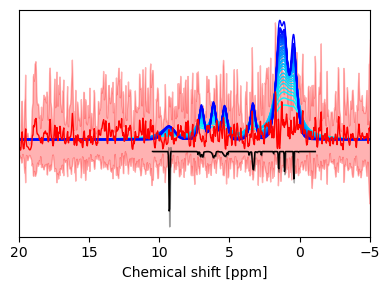

[22000 38000 58000 70000 72000 84000 86000 98000]


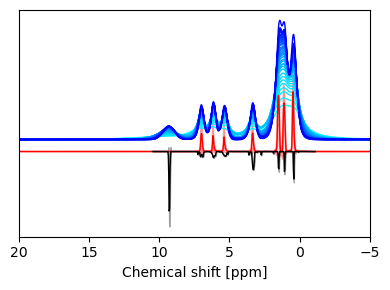

[ 28000  32000  36000  42000  48000  58000  92000 100000]


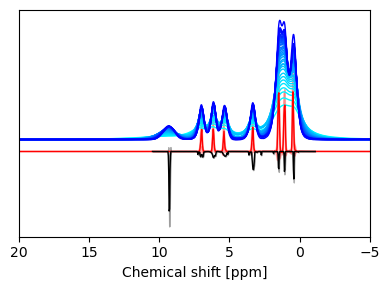

[32000 36000 44000 54000 64000 68000 72000 90000]


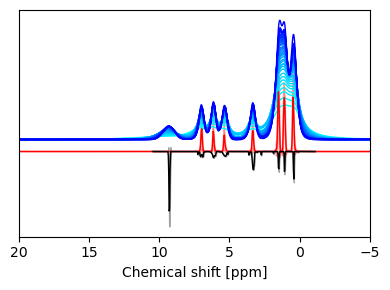

[ 26000  36000  50000  68000  70000  84000  98000 100000]


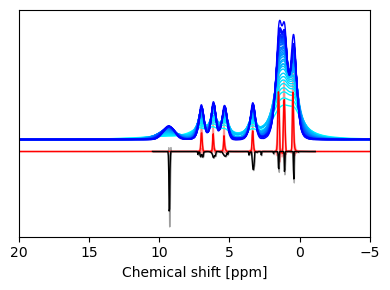

[32000 40000 60000 80000 84000 86000 92000 96000]


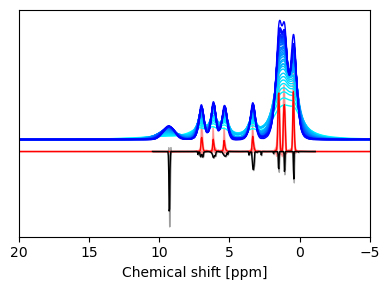

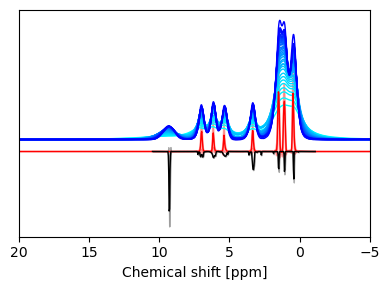

tyrosine


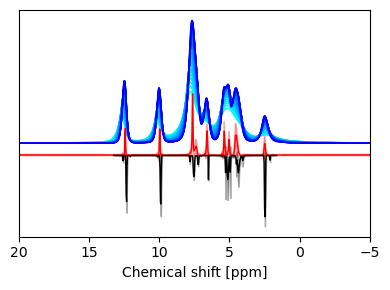

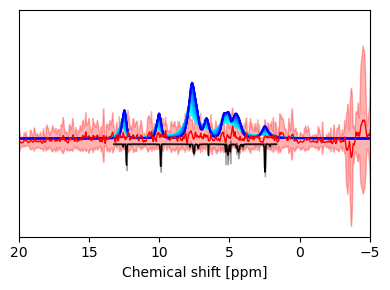

[40000 58000 64000 66000 76000 84000 90000 98000]


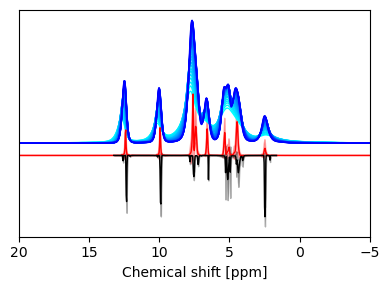

[38000 44000 56000 62000 74000 84000 88000 98000]


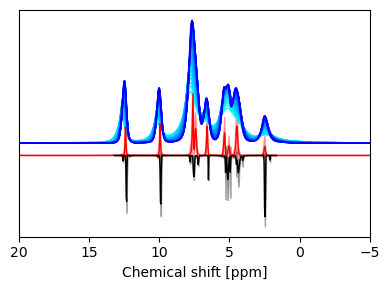

[32000 38000 40000 60000 66000 74000 78000 84000]


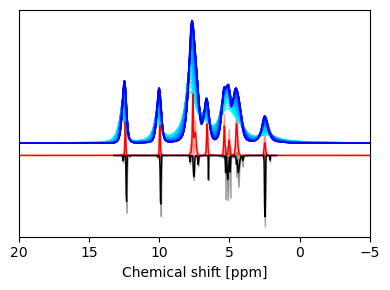

[60000 62000 70000 74000 76000 92000 94000 98000]


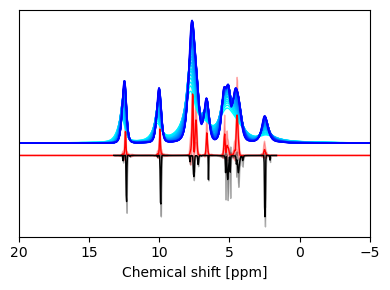

[ 40000  50000  62000  64000  66000  86000  88000 100000]


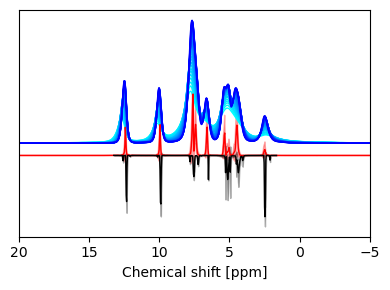

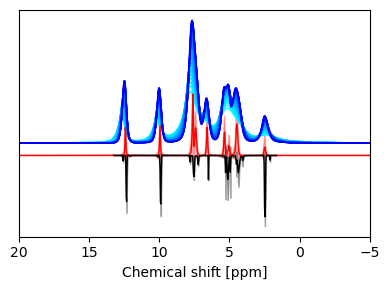

ampicillin


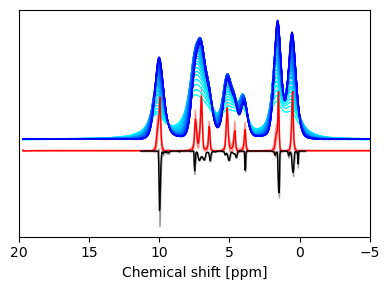

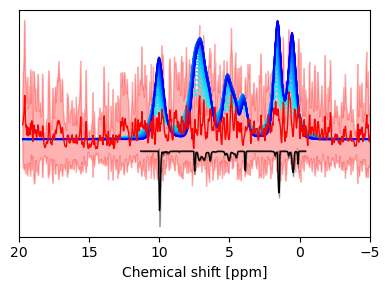

[28000 36000 46000 54000 80000 86000 90000 96000]


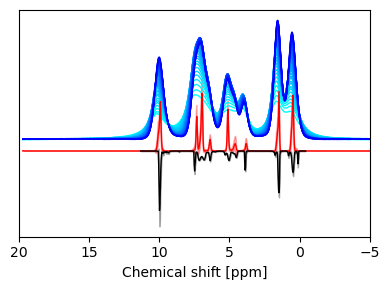

[ 22000  30000  32000  44000  58000  66000  84000 100000]


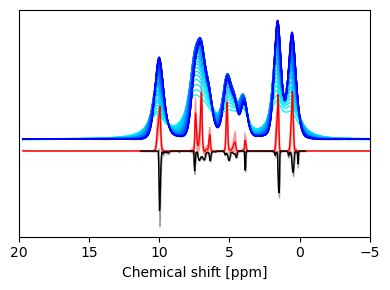

[30000 34000 36000 44000 54000 62000 66000 72000]


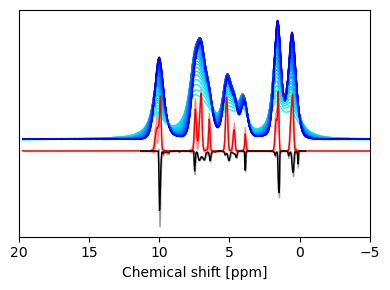

[22000 24000 34000 48000 60000 66000 84000 90000]


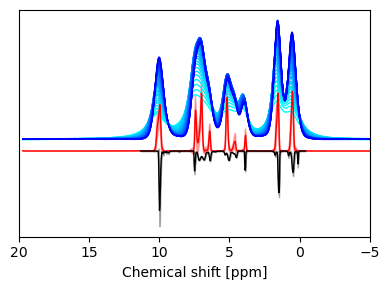

[ 24000  26000  30000  40000  52000  58000  98000 100000]


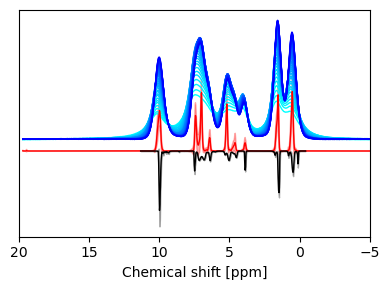

aspala


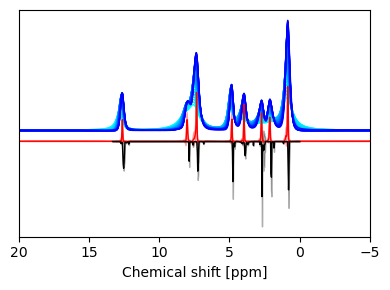

[42000 58000 60000 66000 68000 72000 94000 96000]


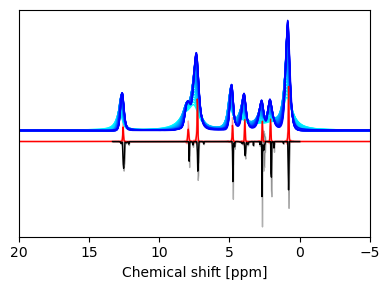

[42000 58000 60000 70000 82000 90000 96000 98000]


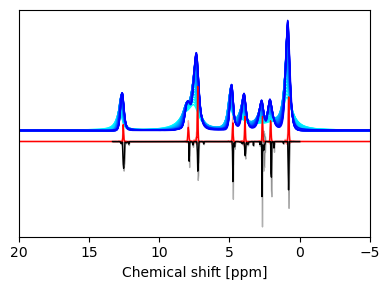

[ 34000  44000  54000  56000  78000  80000  94000 100000]


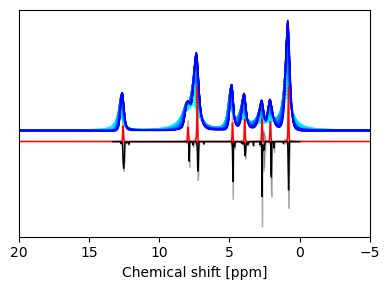

[ 34000  56000  62000  68000  82000  88000  94000 100000]


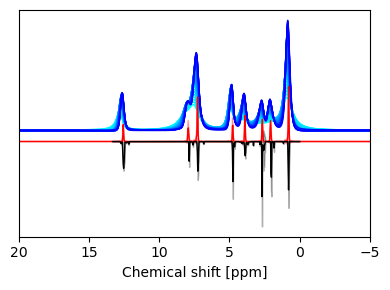

[32000 34000 42000 44000 46000 54000 66000 76000]


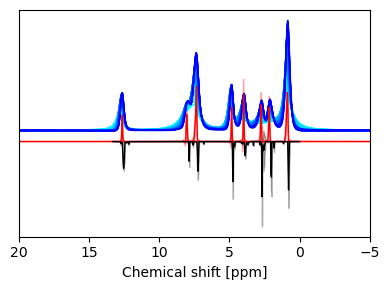

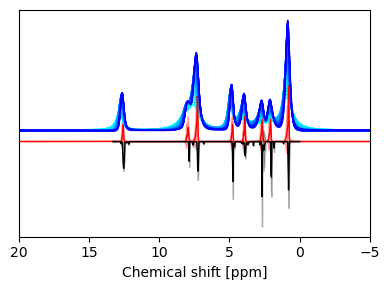

flutamide


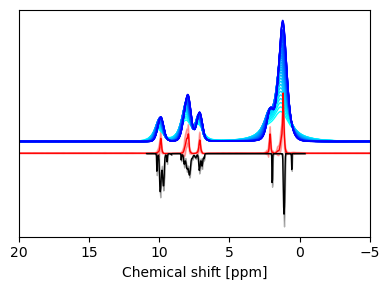

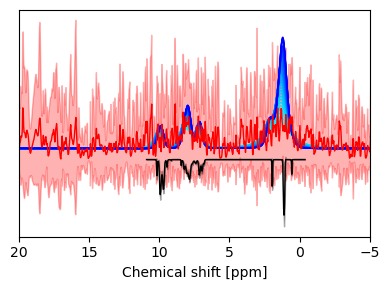

[ 28000  34000  36000  50000  58000  68000  96000 100000]


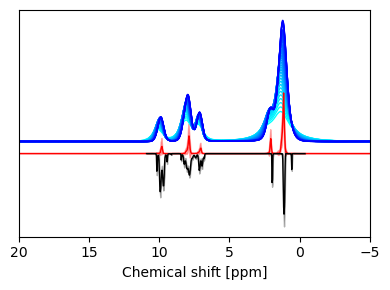

[24000 40000 52000 58000 62000 64000 80000 88000]


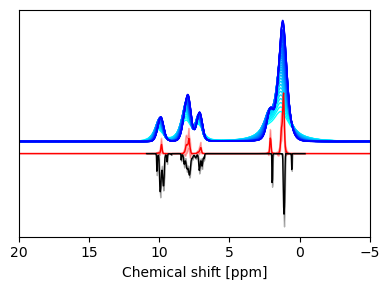

[26000 36000 48000 54000 58000 60000 82000 92000]


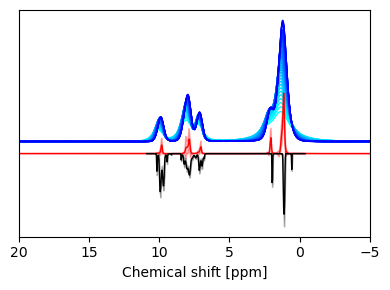

[26000 32000 40000 56000 62000 64000 68000 92000]


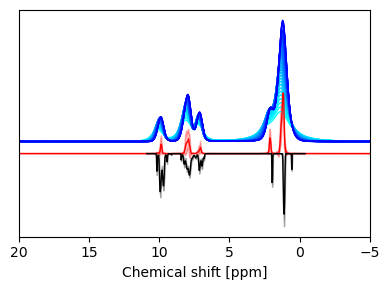

[26000 36000 48000 50000 54000 58000 60000 94000]


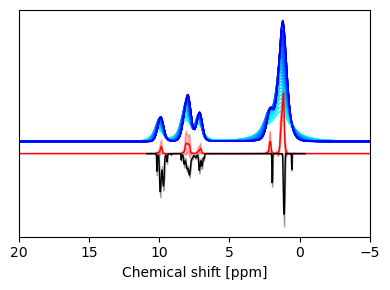

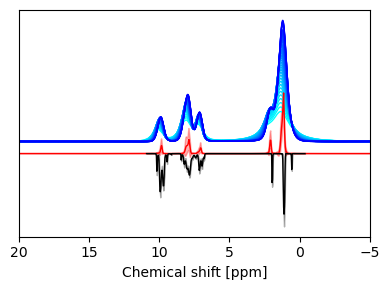

histidine


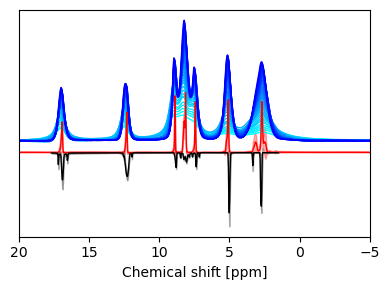

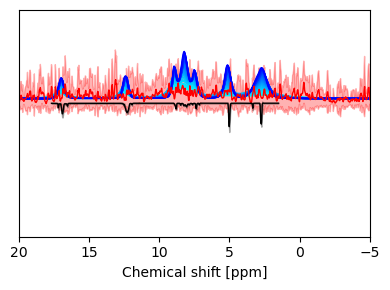

[28000 44000 46000 58000 64000 72000 80000 96000]


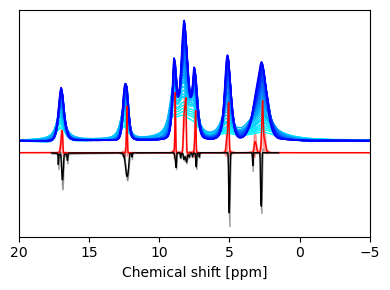

[24000 34000 40000 48000 64000 66000 82000 84000]


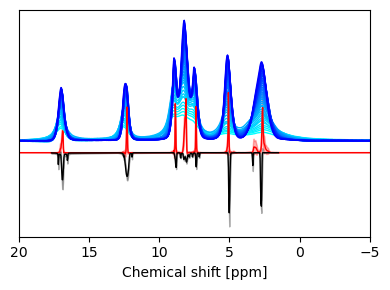

[ 22000  24000  30000  38000  54000  64000  96000 100000]


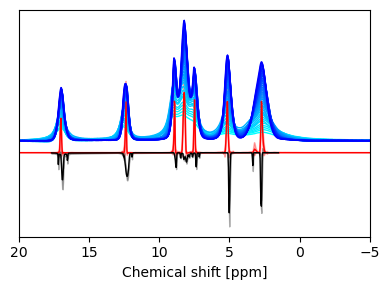

[ 26000  44000  46000  54000  60000  94000  98000 100000]


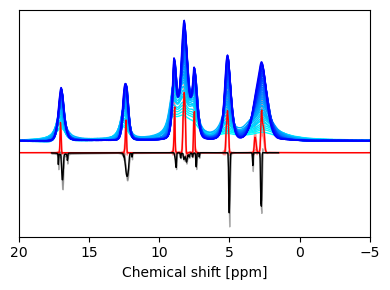

[34000 36000 40000 56000 60000 66000 80000 84000]


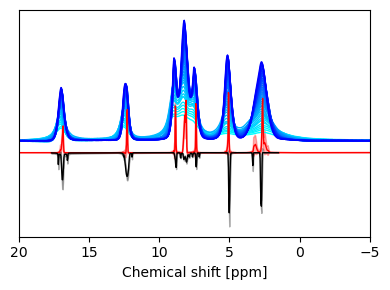

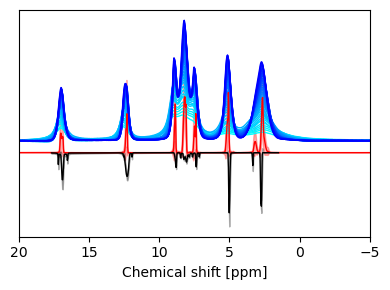

thymol


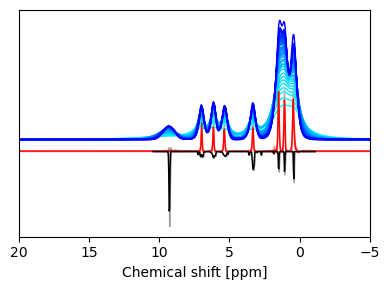

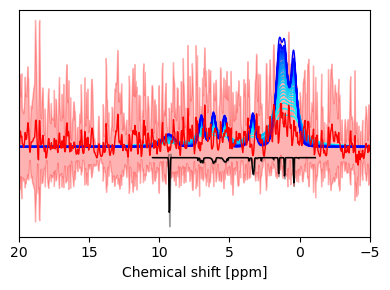

[22000 36000 50000 54000 78000 80000 82000 88000]


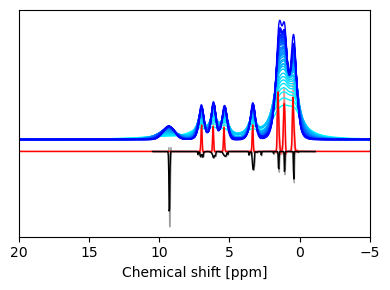

[28000 36000 54000 64000 78000 84000 94000 98000]


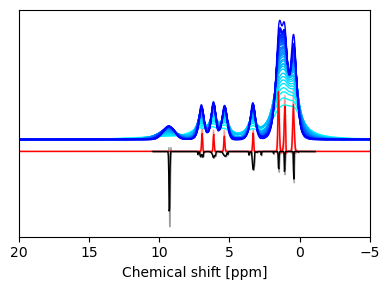

[32000 60000 64000 68000 74000 78000 96000 98000]


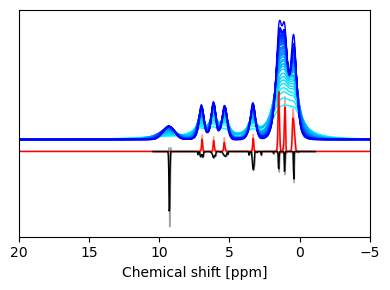

[22000 26000 34000 40000 54000 86000 88000 96000]


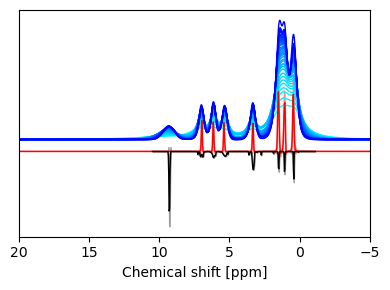

[24000 52000 62000 70000 78000 84000 86000 98000]


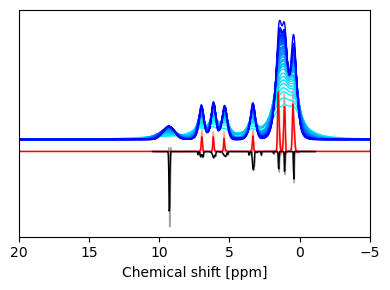

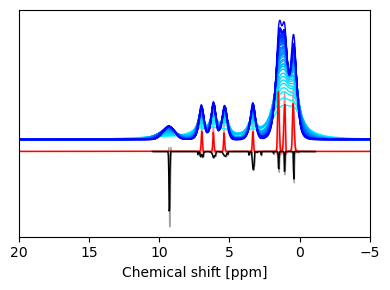

tyrosine


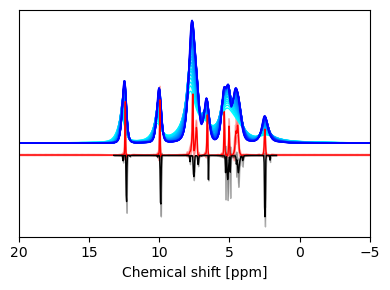

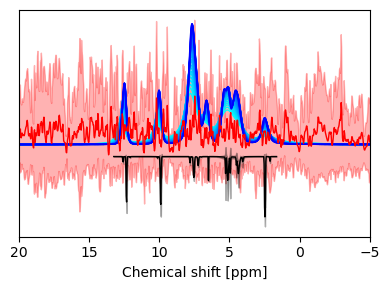

[ 44000  50000  58000  60000  68000  70000  78000 100000]


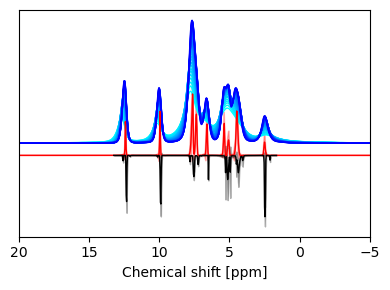

[ 32000  36000  62000  74000  78000  84000  96000 100000]


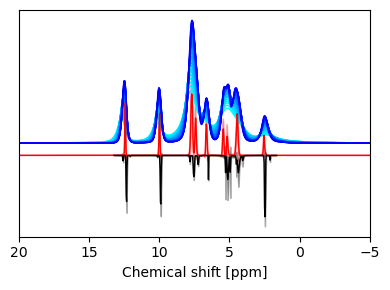

[32000 36000 38000 42000 50000 70000 76000 98000]


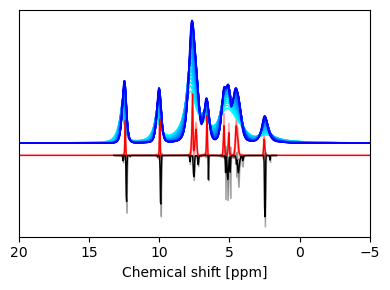

[38000 42000 46000 50000 52000 68000 70000 80000]


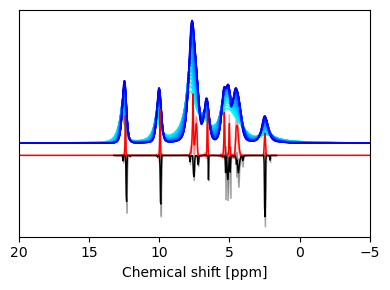

[36000 44000 54000 56000 74000 82000 92000 94000]


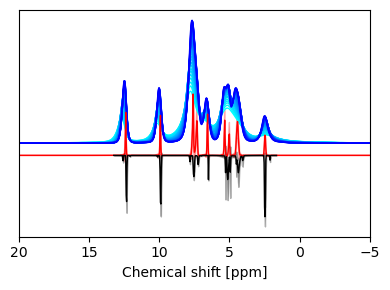

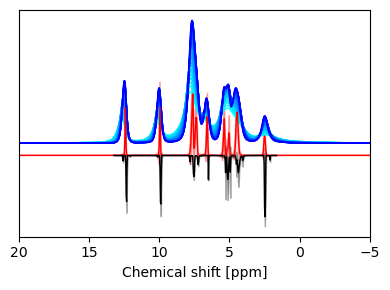

ampicillin


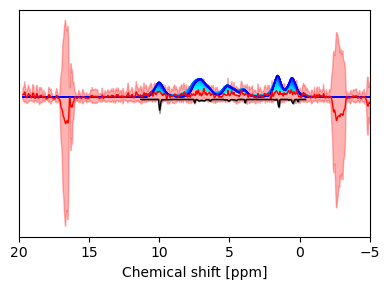

[28000 44000 52000 54000 64000 68000 70000 88000]


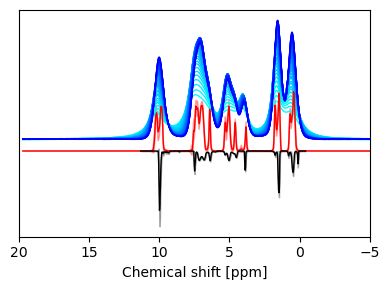

[24000 28000 40000 76000 78000 86000 90000 94000]


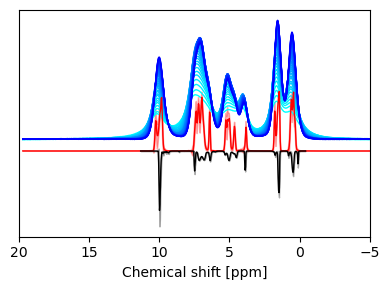

[28000 32000 42000 52000 68000 70000 78000 94000]


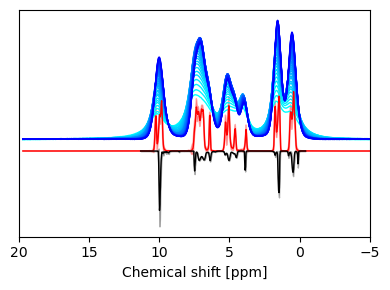

[32000 34000 36000 40000 52000 72000 84000 88000]


[28000 30000 38000 40000 48000 52000 78000 96000]


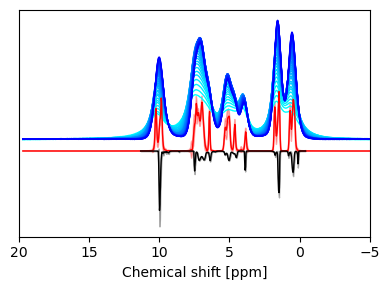

aspala


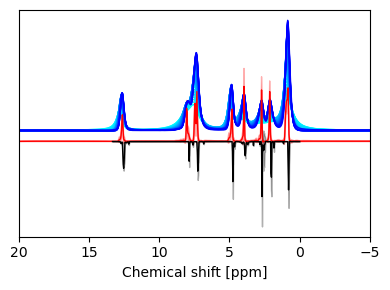

[ 30000  38000  44000  50000  72000  74000  98000 100000]


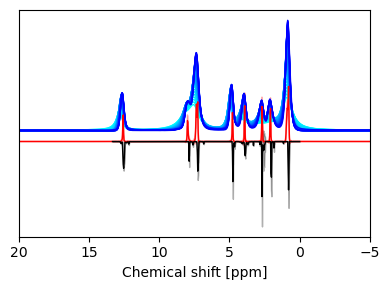

[ 30000  32000  38000  48000  50000  82000  92000 100000]


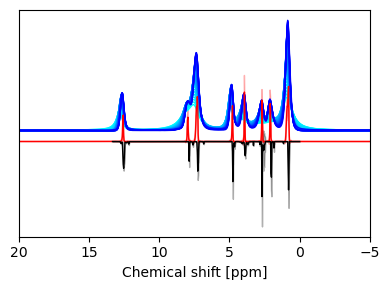

[30000 40000 42000 44000 54000 66000 76000 84000]


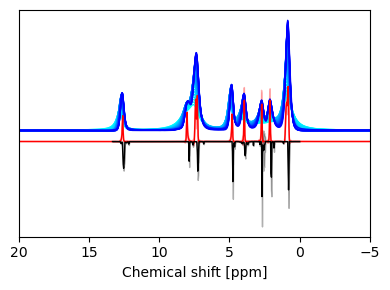

[40000 46000 58000 66000 80000 88000 92000 94000]


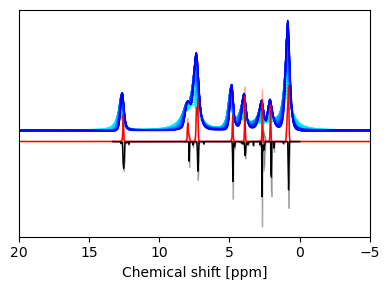

[32000 36000 46000 50000 66000 84000 90000 94000]


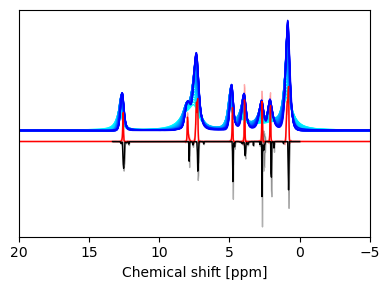

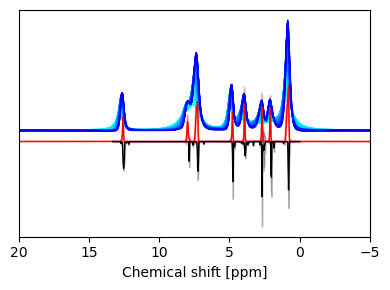

flutamide


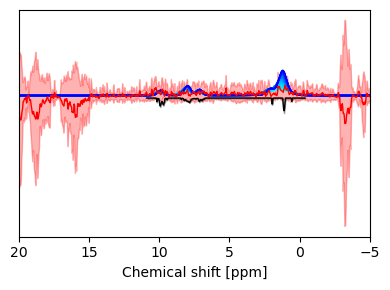

[22000 24000 30000 70000 76000 80000 96000 98000]


[ 26000  30000  34000  40000  44000  54000  96000 100000]


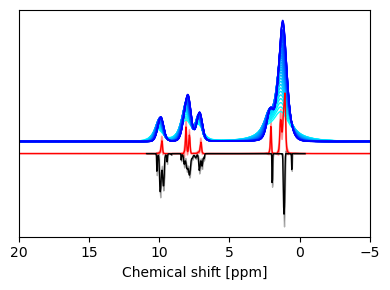

[ 22000  48000  56000  58000  66000  68000  78000 100000]


[30000 60000 64000 70000 72000 76000 80000 94000]


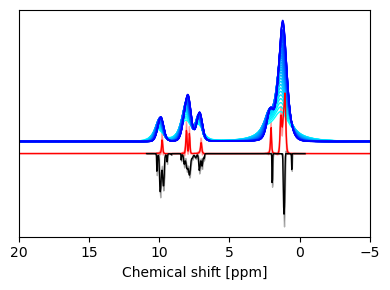

[22000 24000 46000 50000 70000 76000 80000 84000]


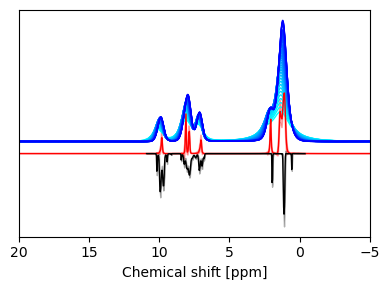

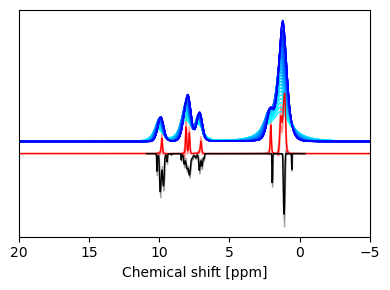

histidine


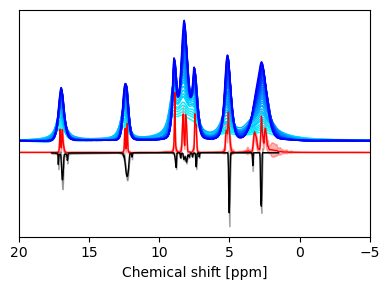

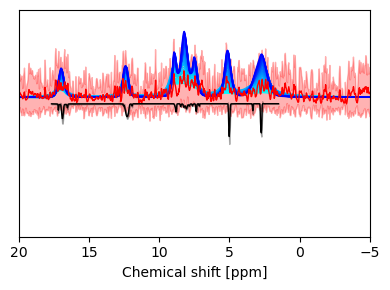

[26000 30000 58000 60000 64000 68000 78000 86000]


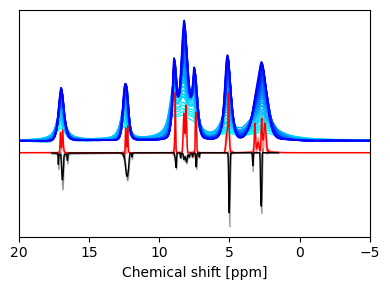

[32000 34000 48000 50000 56000 62000 66000 70000]


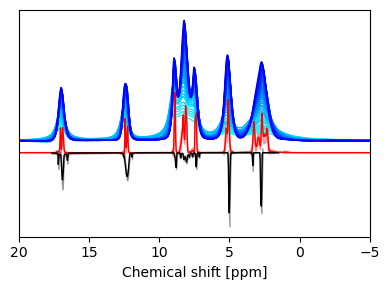

[24000 32000 48000 58000 60000 74000 88000 98000]


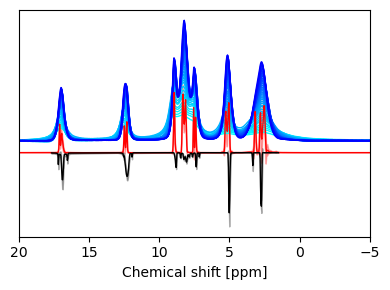

[30000 34000 38000 46000 52000 58000 66000 96000]


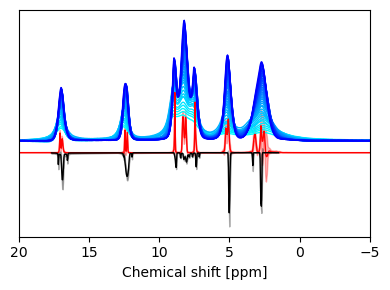

[30000 36000 42000 46000 48000 54000 92000 96000]


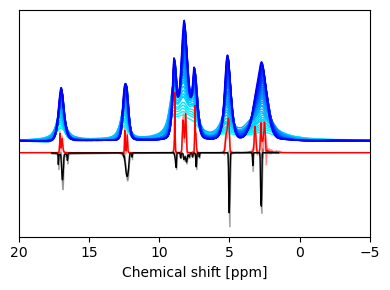

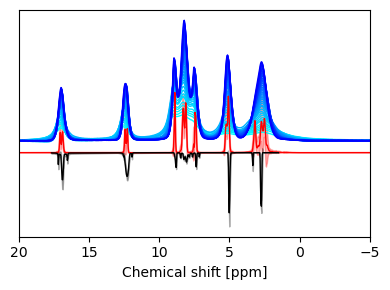

thymol


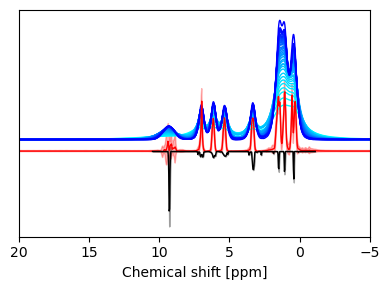

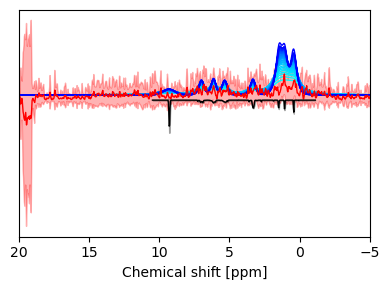

[46000 54000 66000 68000 72000 76000 90000 94000]


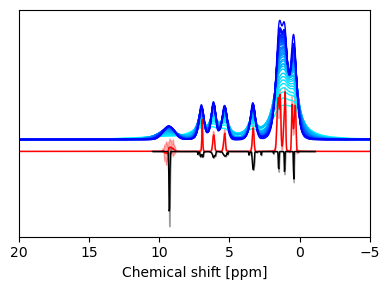

[ 26000  30000  38000  50000  54000  72000  90000 100000]


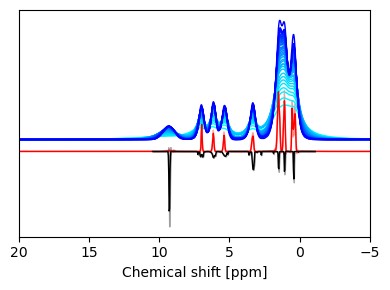

[ 40000  46000  64000  68000  80000  88000  98000 100000]


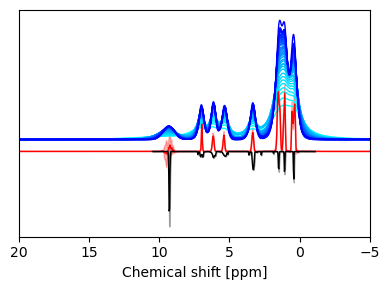

[28000 32000 38000 56000 66000 78000 90000 92000]


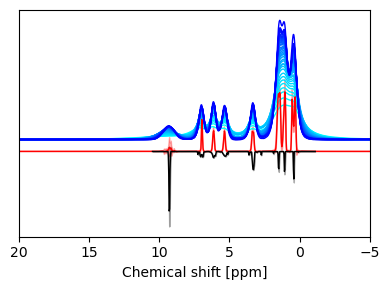

[24000 26000 30000 56000 78000 82000 94000 96000]


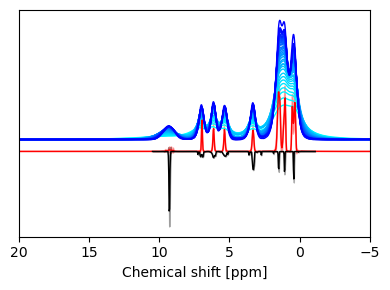

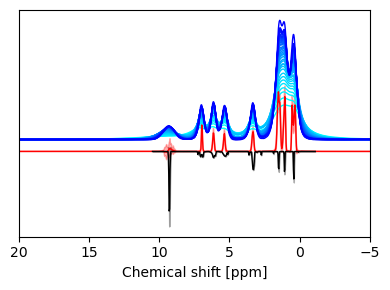

tyrosine


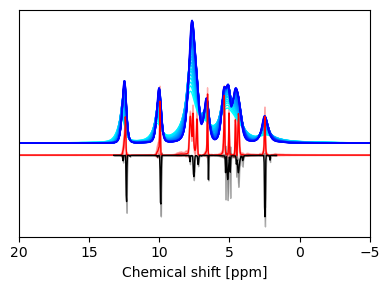

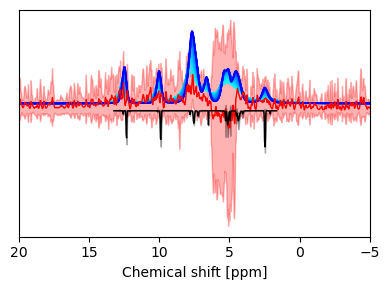

[40000 42000 48000 54000 58000 70000 72000 86000]


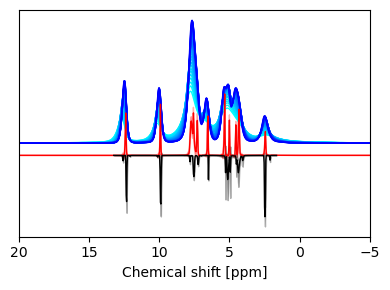

[34000 38000 42000 54000 60000 66000 72000 90000]


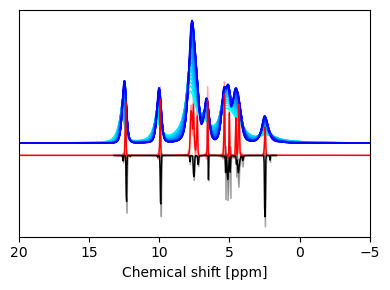

[32000 40000 42000 66000 68000 74000 82000 98000]


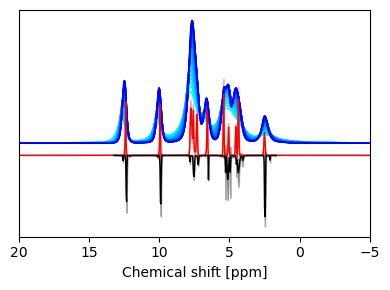

[36000 40000 50000 52000 74000 76000 86000 92000]


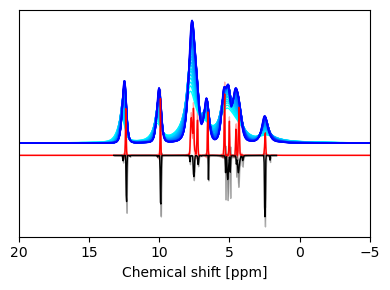

[50000 52000 60000 74000 86000 88000 94000 98000]


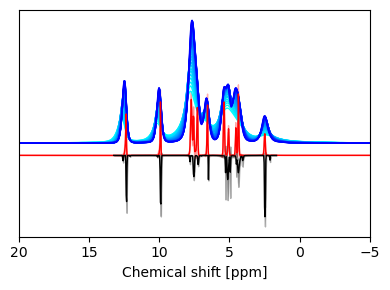

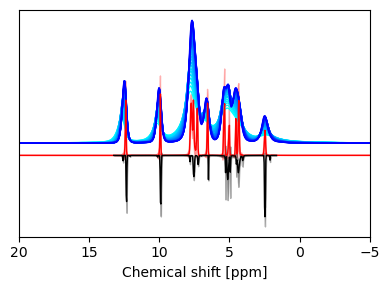

ampicillin


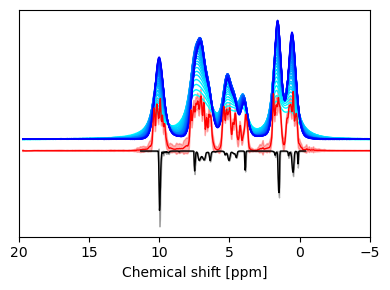

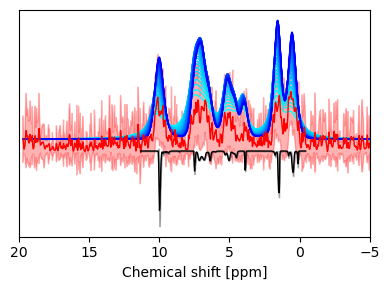

[28000 34000 36000 40000 58000 80000 86000 88000]


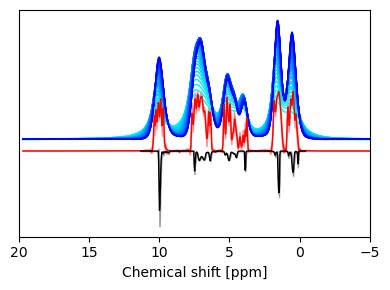

[46000 58000 74000 80000 82000 88000 90000 96000]


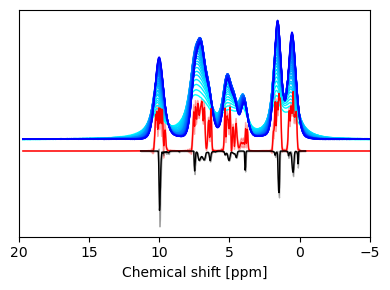

[32000 44000 58000 60000 66000 72000 84000 90000]


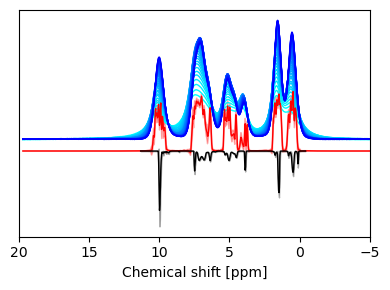

[26000 38000 48000 50000 66000 72000 82000 86000]


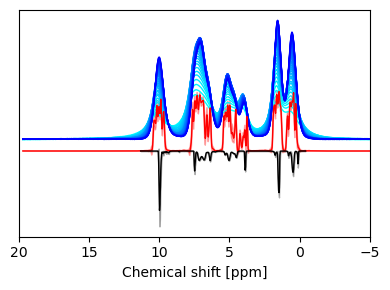

[36000 38000 46000 58000 70000 78000 84000 98000]


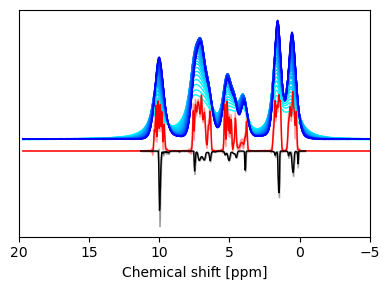

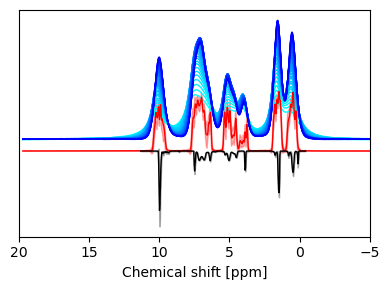

aspala


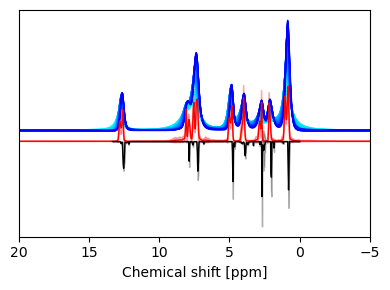

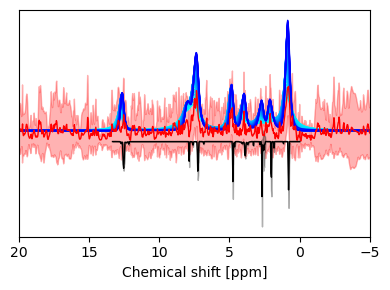

[ 36000  50000  52000  56000  66000  82000  98000 100000]


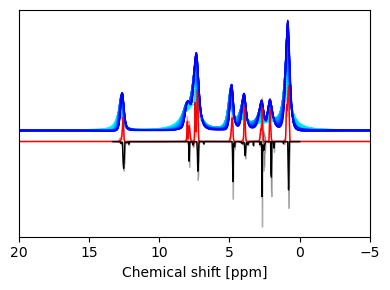

[32000 36000 50000 62000 64000 70000 72000 84000]


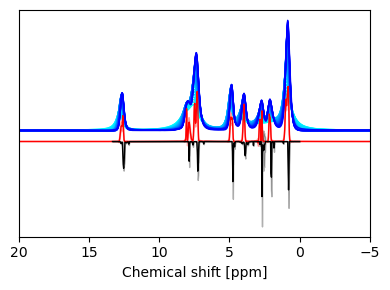

[ 30000  32000  36000  48000  54000  66000  74000 100000]


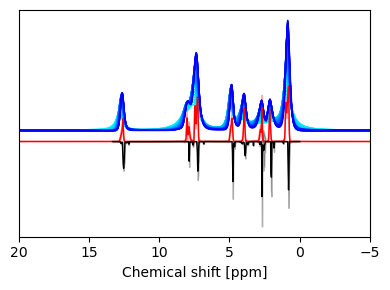

[34000 46000 60000 70000 74000 80000 82000 96000]


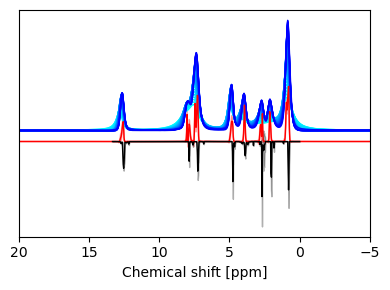

[32000 36000 72000 78000 80000 86000 90000 94000]


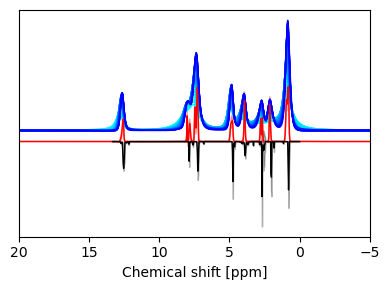

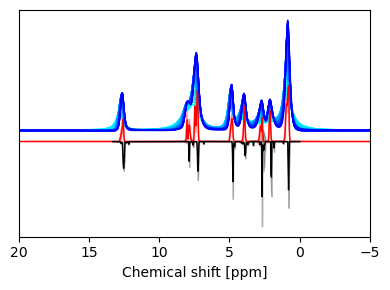

flutamide


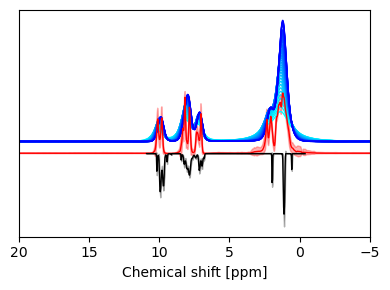

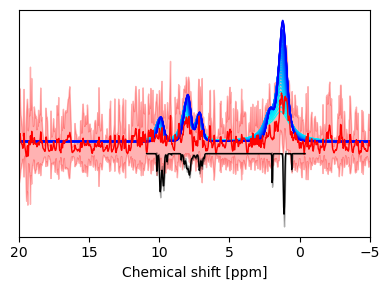

[ 22000  38000  42000  62000  72000  76000  94000 100000]


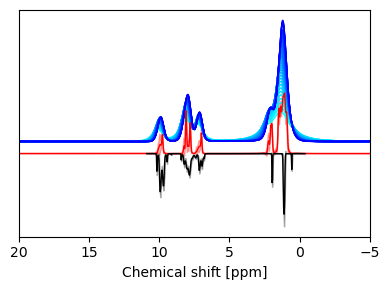

[30000 34000 38000 46000 48000 50000 56000 84000]


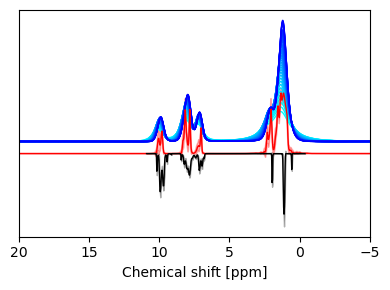

[36000 54000 58000 72000 74000 78000 88000 98000]


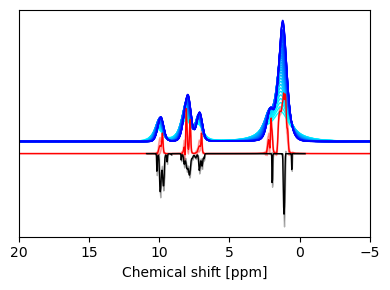

[22000 30000 34000 50000 68000 70000 78000 84000]


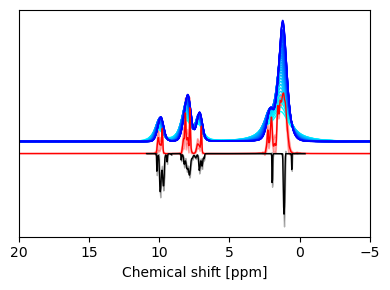

[32000 34000 40000 48000 50000 56000 60000 96000]


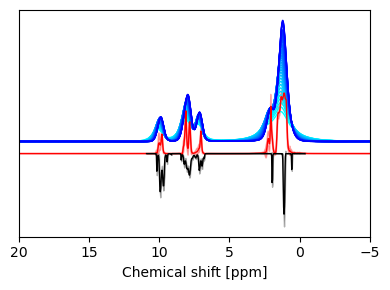

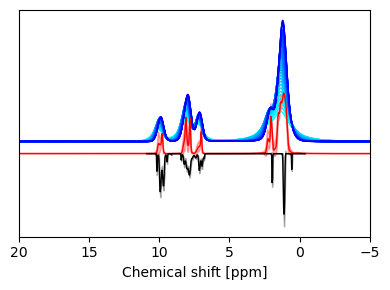

histidine


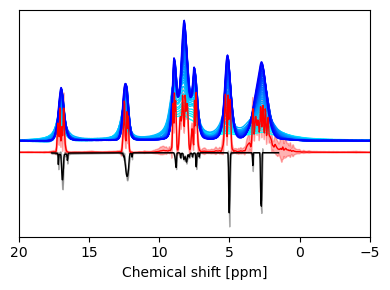

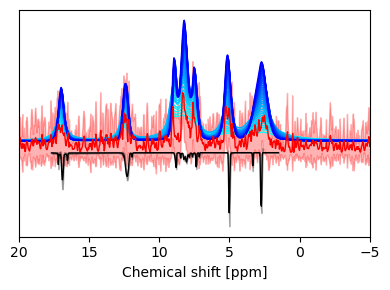

[ 26000  28000  32000  50000  74000  76000  94000 100000]


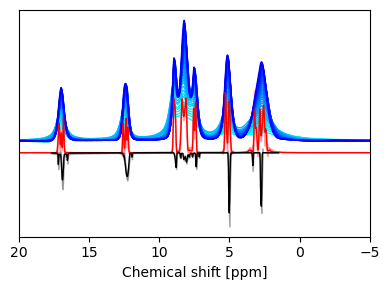

[ 26000  38000  50000  64000  78000  94000  96000 100000]


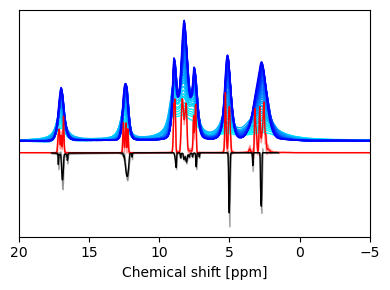

[26000 32000 38000 42000 60000 62000 68000 84000]


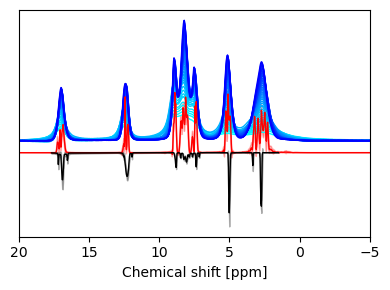

[26000 30000 54000 64000 78000 80000 94000 96000]


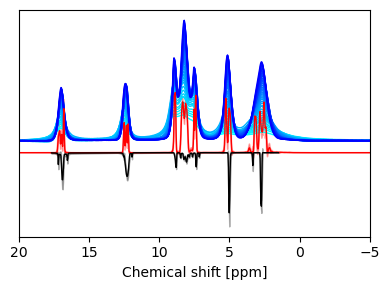

[ 36000  38000  40000  48000  82000  92000  96000 100000]


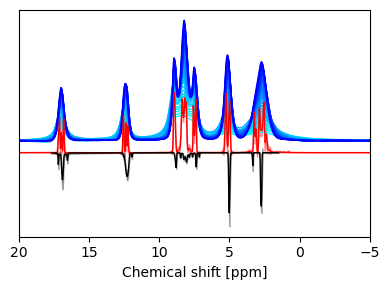

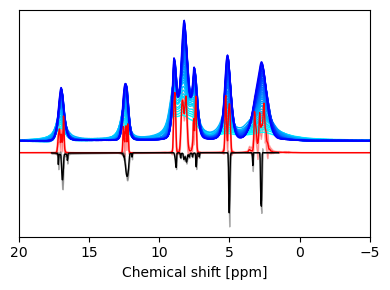

thymol


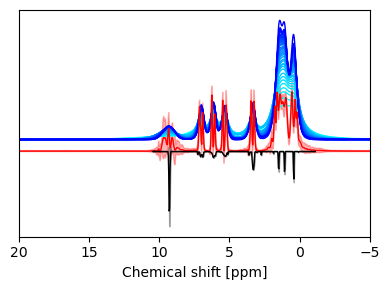

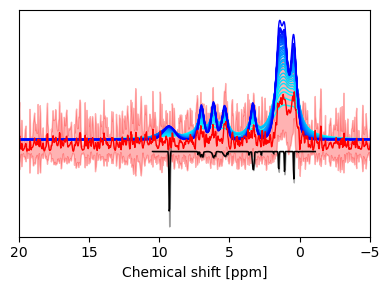

[ 32000  38000  42000  44000  80000  92000  96000 100000]


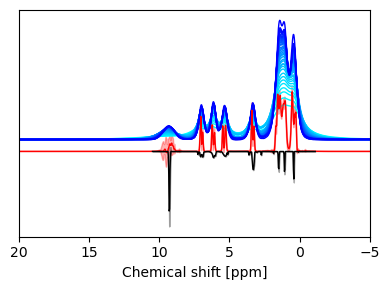

[ 24000  28000  46000  52000  54000  80000  88000 100000]


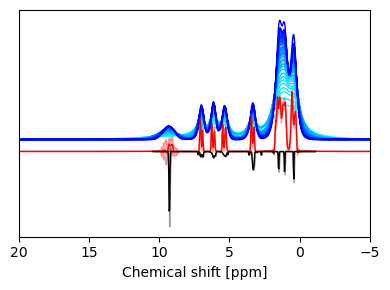

[22000 28000 30000 36000 62000 64000 82000 90000]


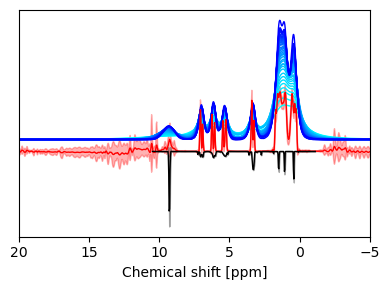

[40000 62000 72000 82000 84000 88000 96000 98000]


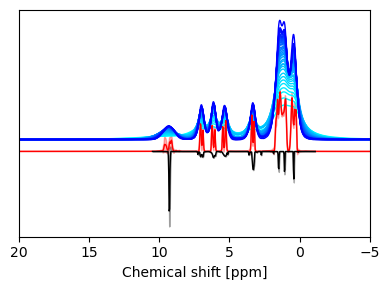

[24000 42000 46000 48000 68000 88000 90000 96000]


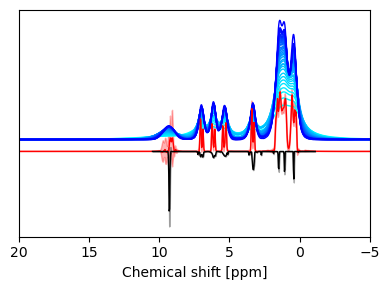

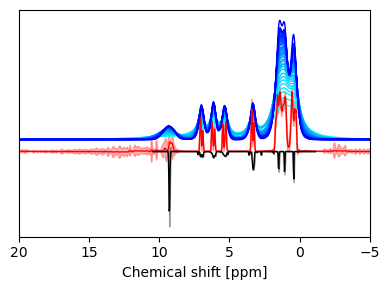

tyrosine


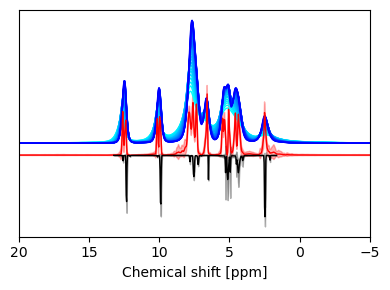

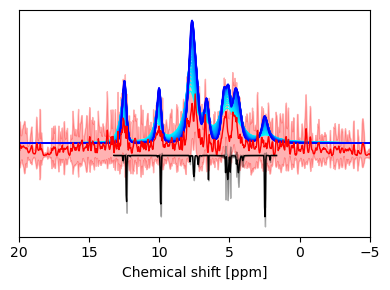

[32000 46000 54000 56000 58000 78000 86000 96000]


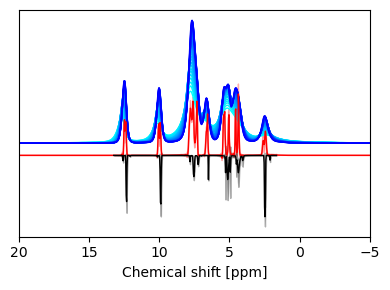

[34000 44000 52000 58000 76000 78000 82000 90000]


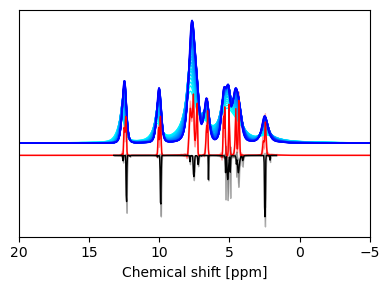

[32000 34000 46000 52000 62000 66000 68000 74000]


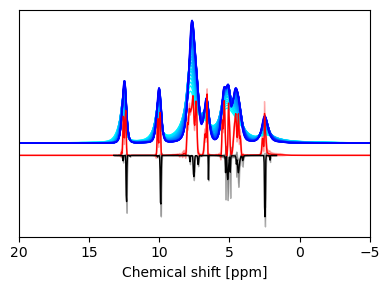

[32000 38000 48000 54000 60000 64000 70000 76000]


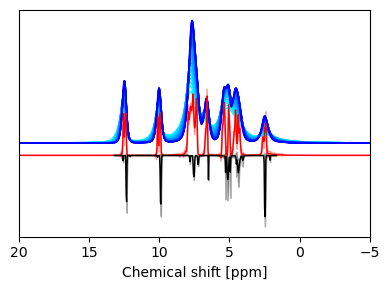

[32000 40000 54000 58000 60000 76000 80000 98000]


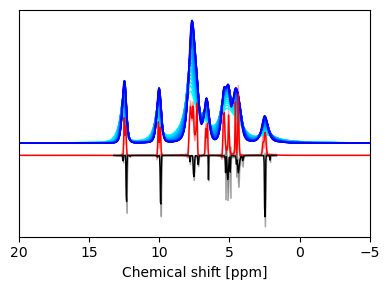

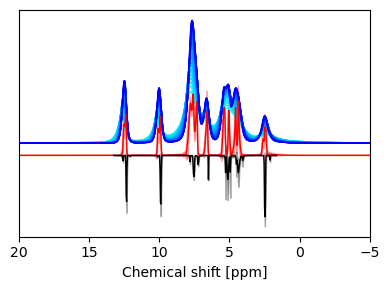

In [63]:
if eval_exp:
    
    # Load best model
    net.load_state_dict(torch.load(in_dir + f"checkpoint_{best_chk+1}_network", map_location=torch.device("cpu")))
    
    fdir = fig_dir + "eval_exp/"
    if not os.path.exists(fdir):
        os.mkdir(fdir)
        
    for xscale in x_scales:
        for compound in exp_compounds:
            r = exp_range[compound]
            print(compound)
            ppm, X, ys_ppms, ys_part_means, ys_part_stds, ws = extract_exp(iso_dir, compound, exp_parts[compound])

            ymax = np.max(ys_part_means)
            ys_part_means /= ymax / 0.5
            ys_part_stds /= ymax / 0.5

            ppm = ppm[r[0]:r[1]]
            X = X[:, r[0]:r[1]] / np.max(X)

            X_torch, ws = make_input(X, ws, data_pars)

            # Selected rates
            if evals["sel"]:

                w_inds = []
                for w in sel_wrs:
                    w_inds.append(np.argmin(np.abs(ws - w)))

                X_net = X_torch[:, w_inds]
                X_net /= torch.max(X_net) / xscale

                y_pred, y_std, ys = net(X_net)

                y_pred = y_pred.detach().numpy()[0, 0]
                y_std = y_std.detach().numpy()[0, 0]

                ymax = np.max(y_pred)
                y_pred /= ymax / 0.5

                y_std /= ymax / 0.5

                plot_exp_vs_pred(ppm, X, y_pred, y_std, ys_ppms, ys_part_means, ys_part_stds, y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, save=f"{fdir}{compound}_preds_sel_scale_{xscale}.pdf")            

            # All rates
            if evals["all"]:
                w_inds = np.argsort(ws)

                X_net = X_torch[:, w_inds]
                X_net /= torch.max(X_net) / xscale

                y_pred, y_std, ys = net(X_net)

                y_pred = y_pred.detach().numpy()[0, 0]
                y_std = y_std.detach().numpy()[0, 0]

                ymax = np.max(y_pred)
                y_pred /= ymax / 0.5

                y_std /= ymax / 0.5

                plot_exp_vs_pred(ppm, X, y_pred, y_std, ys_ppms, ys_part_means, ys_part_stds, y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, save=f"{fdir}{compound}_preds_all_scale_{xscale}.pdf")            

            # Randomly selected rates
            if evals["rand"] > 0:
                all_ys = []
                for i in range(evals["rand"]):
                    
                    w_inds = np.sort(np.random.choice(range(X.shape[0]), size=data_pars["nw"], replace=False))
                    
                    print(ws[w_inds])

                    X_net = X_torch[:, w_inds]
                    X_net /= torch.max(X_net) / xscale

                    y_pred, y_std, ys = net(X_net)

                    y_pred = y_pred.detach().numpy()[0, 0]
                    y_std = y_std.detach().numpy()[0, 0]

                    ymax = np.max(y_pred)
                    y_pred /= ymax / 0.5

                    y_std /= ymax / 0.5
                    
                    all_ys.append(ys.detach().numpy()[:, 0, 0])

                    plot_exp_vs_pred(ppm, X, y_pred, y_std, ys_ppms, ys_part_means, ys_part_stds, y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, save=f"{fdir}{compound}_preds_rand_{i}_scale_{xscale}.pdf")            
                
                ys = np.concatenate(all_ys, axis=0)
                y_pred = np.mean(ys, axis=0)
                y_std = np.std(ys, axis=0)
                
                ymax = np.max(y_pred)
                y_pred /= ymax / 0.5

                y_std /= ymax / 0.5

                plot_exp_vs_pred(ppm, X, y_pred, y_std, ys_ppms, ys_part_means, ys_part_stds, y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, save=f"{fdir}{compound}_preds_rands_scale_{xscale}.pdf")            

In [48]:
y_std.shape

(1000,)

In [45]:
x.shape

(1000,)

In [40]:
mean_preds[0].shape

(1000,)